In [1]:
from matplotlib.gridspec import GridSpec
from utils.binaries import *
from utils.plotting import *
from datetime import datetime
import pickle
import os

from utils.Auger.FD import get_mirror_or_telescope

08:20:54 (   +1.8s) [INFO   ] -- import logging
08:20:54 (    +1ms) [INFO   ] -- import numpy as np
08:20:54 (    +5ms) [INFO   ] -- import uncertainties
08:20:54 (    +1ms) [INFO   ] -- import numpy as np
08:20:54 (    +5ms) [INFO   ] -- import uncertainties
08:20:54 (  +210ms) [INFO   ] -- import pandas as pd
08:20:54 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
08:20:54 (    +1ms) [INFO   ] -- import binaries.tools as tools
08:20:54 (  +214ms) [INFO   ] -- import matplotlib.pyplot as plt
08:20:54 (  +424ms) [INFO   ] -- import seaborn as so
08:20:54 (    +2ms) [INFO   ] -- import plotting.tools as plot
08:20:54 (    +8ms) [DEBUG  ] -- font size set to 9.5
08:20:54 (    +1ms) [DEBUG  ] -- label size set to 13.0
08:20:54 (    +0ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
08:20:54 (    +1ms) [DEBUG  ] -- markersize set to 2.0
08:20:54 (    +1ms) [DEBUG  ] -- usetex set to False


In [2]:
def load_file(pickle_location: str):
    with open(pickle_location, 'rb') as f:
        return pickle.load(f)
    
def select_hist(data, bins, cuts, ax=None, **kwargs):

    if ax is None: ax = plt.gca()
    data = np.array(data)
    orientation = kwargs.get('orientation', 'vertical')
    c = kwargs.get('color', 'k')

    select = np.ma.masked_where(((cuts[0] <= data) & (data < cuts[1])), data).mask
    # percentage_accept = (1 - (len(data) - sum(select)) / len(data)) * 100
    # _ = ax.hist(data, bins=bins, label=f'accept {percentage_accept:.1f}%', histtype='step', align='mid', orientation=orientation, color='k')
    _ = ax.hist(data, bins=bins, histtype='step', align='mid', orientation=orientation, color='k')
    _ = ax.hist(data[select], bins=bins, fc='g', alpha=0.5, align='mid', orientation=orientation, color='k')
    _ = ax.hist(data[~select], bins=bins, fc='r', alpha=0.5, align='mid', orientation=orientation, color='k')

    for cut in cuts:
        if orientation == 'horizontal':
            ax.axhline(cut, ls='-.', alpha=0.2, zorder=0)
        else:
            ax.axvline(cut, ls='-.', alpha=0.2, zorder=0)

    ax.text(1 if orientation == 'horizontal' else 0, 1, 
            rf"$\mu\,=\,{np.nanmean(data):.2f}$, $\sigma\,=\,{np.nanstd(data):.3f}$",
            transform=ax.transAxes,
            ha='left',
            va='top' if orientation == 'horizontal' else 'bottom',
            rotation=-90 if orientation == 'horizontal' else 0)

    return select

def AddApertureEtcToPlot(ax, unit='mm', filterStructure=True, zorder=10):
    """
    Adds Aperture, Lens, Filterstructure (of most telescopes) to an given axis ax!
    args: axis, unit
    return: nothing
    """
    if unit == 'mm':
        uf = 1
        ax.set_xlabel(r'$x$ / mm')
        ax.set_ylabel(r'$y$ / mm')
    elif unit == 'm':
        uf = 1e-3
        ax.set_xlabel(r'$x$ / m')
        ax.set_ylabel(r'$y$ / m')
    else:
        raise ValueError('Only m and mm are supported!')
    aperture = plt.Circle((0, 0), 1100 * uf, color='tab:red', fill=False, lw=2, zorder=zorder, alpha=0.5)
    ax.add_artist(aperture)
    corrector = plt.Circle((0, 0), 1700 / 2 * uf, color='k', fill=False, ls='--', zorder=zorder)
    if filterStructure:
        ax.plot([-1030 * uf, 1030 * uf], [765 * uf / 2] * 2, color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')
        ax.plot([-1030 * uf, 1030 * uf], [-765 * uf / 2] * 2, color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')
        ax.plot([-450 * uf / 2] * 2, [-1078 * uf, 1076 * uf], color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')
        ax.plot([450 * uf / 2] * 2, [-1078 * uf, 1076 * uf], color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')

        ax.plot([450 * uf / 2 + 460 * uf] * 2, [-850 * uf, 850 * uf], color='grey', alpha=0.3, lw=0.3, zorder=0, ls='solid')
        ax.plot([-450 * uf / 2 - 460 * uf] * 2, [-850 * uf, 850 * uf], color='grey', alpha=0.3, lw=0.3, zorder=0, ls='solid')
    ax.add_artist(corrector)
    ax.set_xlim(-1300 * uf, 1300 * uf)
    ax.set_ylim(-1300 * uf, 1300 * uf)
    ax.set_aspect('equal', 'box')

    return aperture, corrector

def get_mirror_and_time(run_number):

    with open(f'/home/filip/xy-calibration/results/outCorr_{run_number}.txt', 'r') as f:
        info = f.readline()
        mirror = info.split('_')[1]
        date = info.split('_')[-1][:-6]

    return get_mirror_or_telescope(mirror), datetime.strptime(date, "%Y-%m-%d.%H-%M")

In [3]:
base = '/home/filip/Desktop/xy-quality-files'
# base = '/cr/data01/filip/xy-calibration/QualityAssurance'

t_led, t_phd = [], []
drift_t_led, drift_t_phd = [], []
noise_phd, drift_phd = [], []
x, y, s = [], [], []
mean_x, mean_y = [], []
filter_x, filter_y = [], []
cal_a_ratios = []
cal_a_means = []
std_calib_ratios = []
xy_calib = []
missing = []
dates = {}
drift = {}

# telescopes = {
#     'HEAT pre cleaning': ['6020x', '6025', '6031x', 
#                           '05616x', '05621x', '05626x'],
#     'HEAT post cleaning': ['6066', '6070', '6075', '6101'],
#     'Los Leones': ['15672', '15675',
#                    '14453'], # '14443',],
#     'Loma Amarilla': ['12275x', '12279x', '12292x', '12301x', '12307x', '12320x', '12328x',
#                       '11863', '11875', ''],
#     'Coihueco': ['15920x', '15925x', '15934x', '15941x', '15952x', '15959', '15967', '15984x',
#                  '15437', '15443x', '15448', '15468',
#                  '15490x'],
#     'Los Morados': ['12806', '12809', '12819', '12822', '12825', '12830']
# }
# tel_std_calib_ratios = {}

# for telescope, runs in telescopes.items():


    # tel = []
    # heat_factor = 0.5 if 'HEAT' in telescope else 1

for run in os.listdir(base):
    if not run.endswith('.pkl'): continue
    try:
        data = load_file(f"{base}/{run}")
        t_led += list(data['t_led'])
        t_phd += list(data['t_phd'])

        drift_t_led.append(np.corrcoef(data['t_led'], data['time'])[0, 1])
        drift_t_phd.append(np.corrcoef(data['t_phd'], data['time'])[0, 1])
        noise_phd.append(np.std(data['phd_signal']) / np.mean(data['phd_signal']))
        drift_phd.append(np.corrcoef(data['phd_signal'], data['time'])[0, 1])

        # pulse_length += list(data['pulse_length'] * heat_factor)
        missing.append(data['pulses_lost'])

        xs, ys, f = data['flashes']
        x += list(xs)
        y += list(ys) 
        s += list(f / f.max())

        filter_x.append(data['filter_center'][0])
        filter_y.append(data['filter_center'][1])
        mean_x.append(data['signal_center'][0])
        mean_y.append(data['signal_center'][1])
        
        if np.abs(filter_x[-1]) > 25: print(f"misalignment? {run}")
        if np.abs(filter_y[-1]) > 25: print(f"misalignment? {run}")

        cal_a = data['cal_before'] / data['cal_after']
        cal_a_ratios += list(cal_a)
        cal_a_means.append(np.nanmedian(cal_a))
        std_calib_ratio = list(data['xy_corr'] / data['std_calib'])

        if (t := np.mean(data['cal_before'] / data['cal_after'])) > 1.07: print(f'{run}: large drift, {t}')

        std_calib_ratios += std_calib_ratio

        telescope, date = get_mirror_and_time(run.split('_')[-1][:-4])
        if dates.get(telescope, None) is not None:
            dates[telescope] += [date]
            drift[telescope] += [np.mean(data['xy_corr'] / data['std_calib'])]
        else:
            dates[telescope] = [date]
            drift[telescope] = [np.mean(data['xy_corr'] / data['std_calib'])]

        # dates += list([d.timestamp() for d in data['history_dates']] - np.mean([d.timestamp() for d in data['history_dates']]))
        # drift += list(np.mean(data['history_ratios'], axis=1) - np.mean(data['history_ratios']))

        # tel += std_calib_ratio

        # count += 1

    except Exception as e:
        print(f"{run}: {e}")

    # tel_std_calib_ratios[telescope] = tel

# for file in os.listdir(base):
#     if not file.endswith('.pkl'): continue
#     count += 1


stats_12307x.pkl: large drift, 1.0834392254371281
misalignment? stats_15984x.pkl
misalignment? stats_15920x.pkl
misalignment? stats_15443x.pkl
misalignment? stats_16464.pkl


/tmp/ipykernel_4476/977167846.py:70: RuntimeWarning: divide by zero encountered in divide
  std_calib_ratio = list(data['xy_corr'] / data['std_calib'])
/tmp/ipykernel_4476/977167846.py:82: RuntimeWarning: divide by zero encountered in divide
  drift[telescope] = [np.mean(data['xy_corr'] / data['std_calib'])]
/tmp/ipykernel_4476/977167846.py:79: RuntimeWarning: divide by zero encountered in divide
  drift[telescope] += [np.mean(data['xy_corr'] / data['std_calib'])]


/tmp/ipykernel_4476/633095856.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_4476/633095856.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


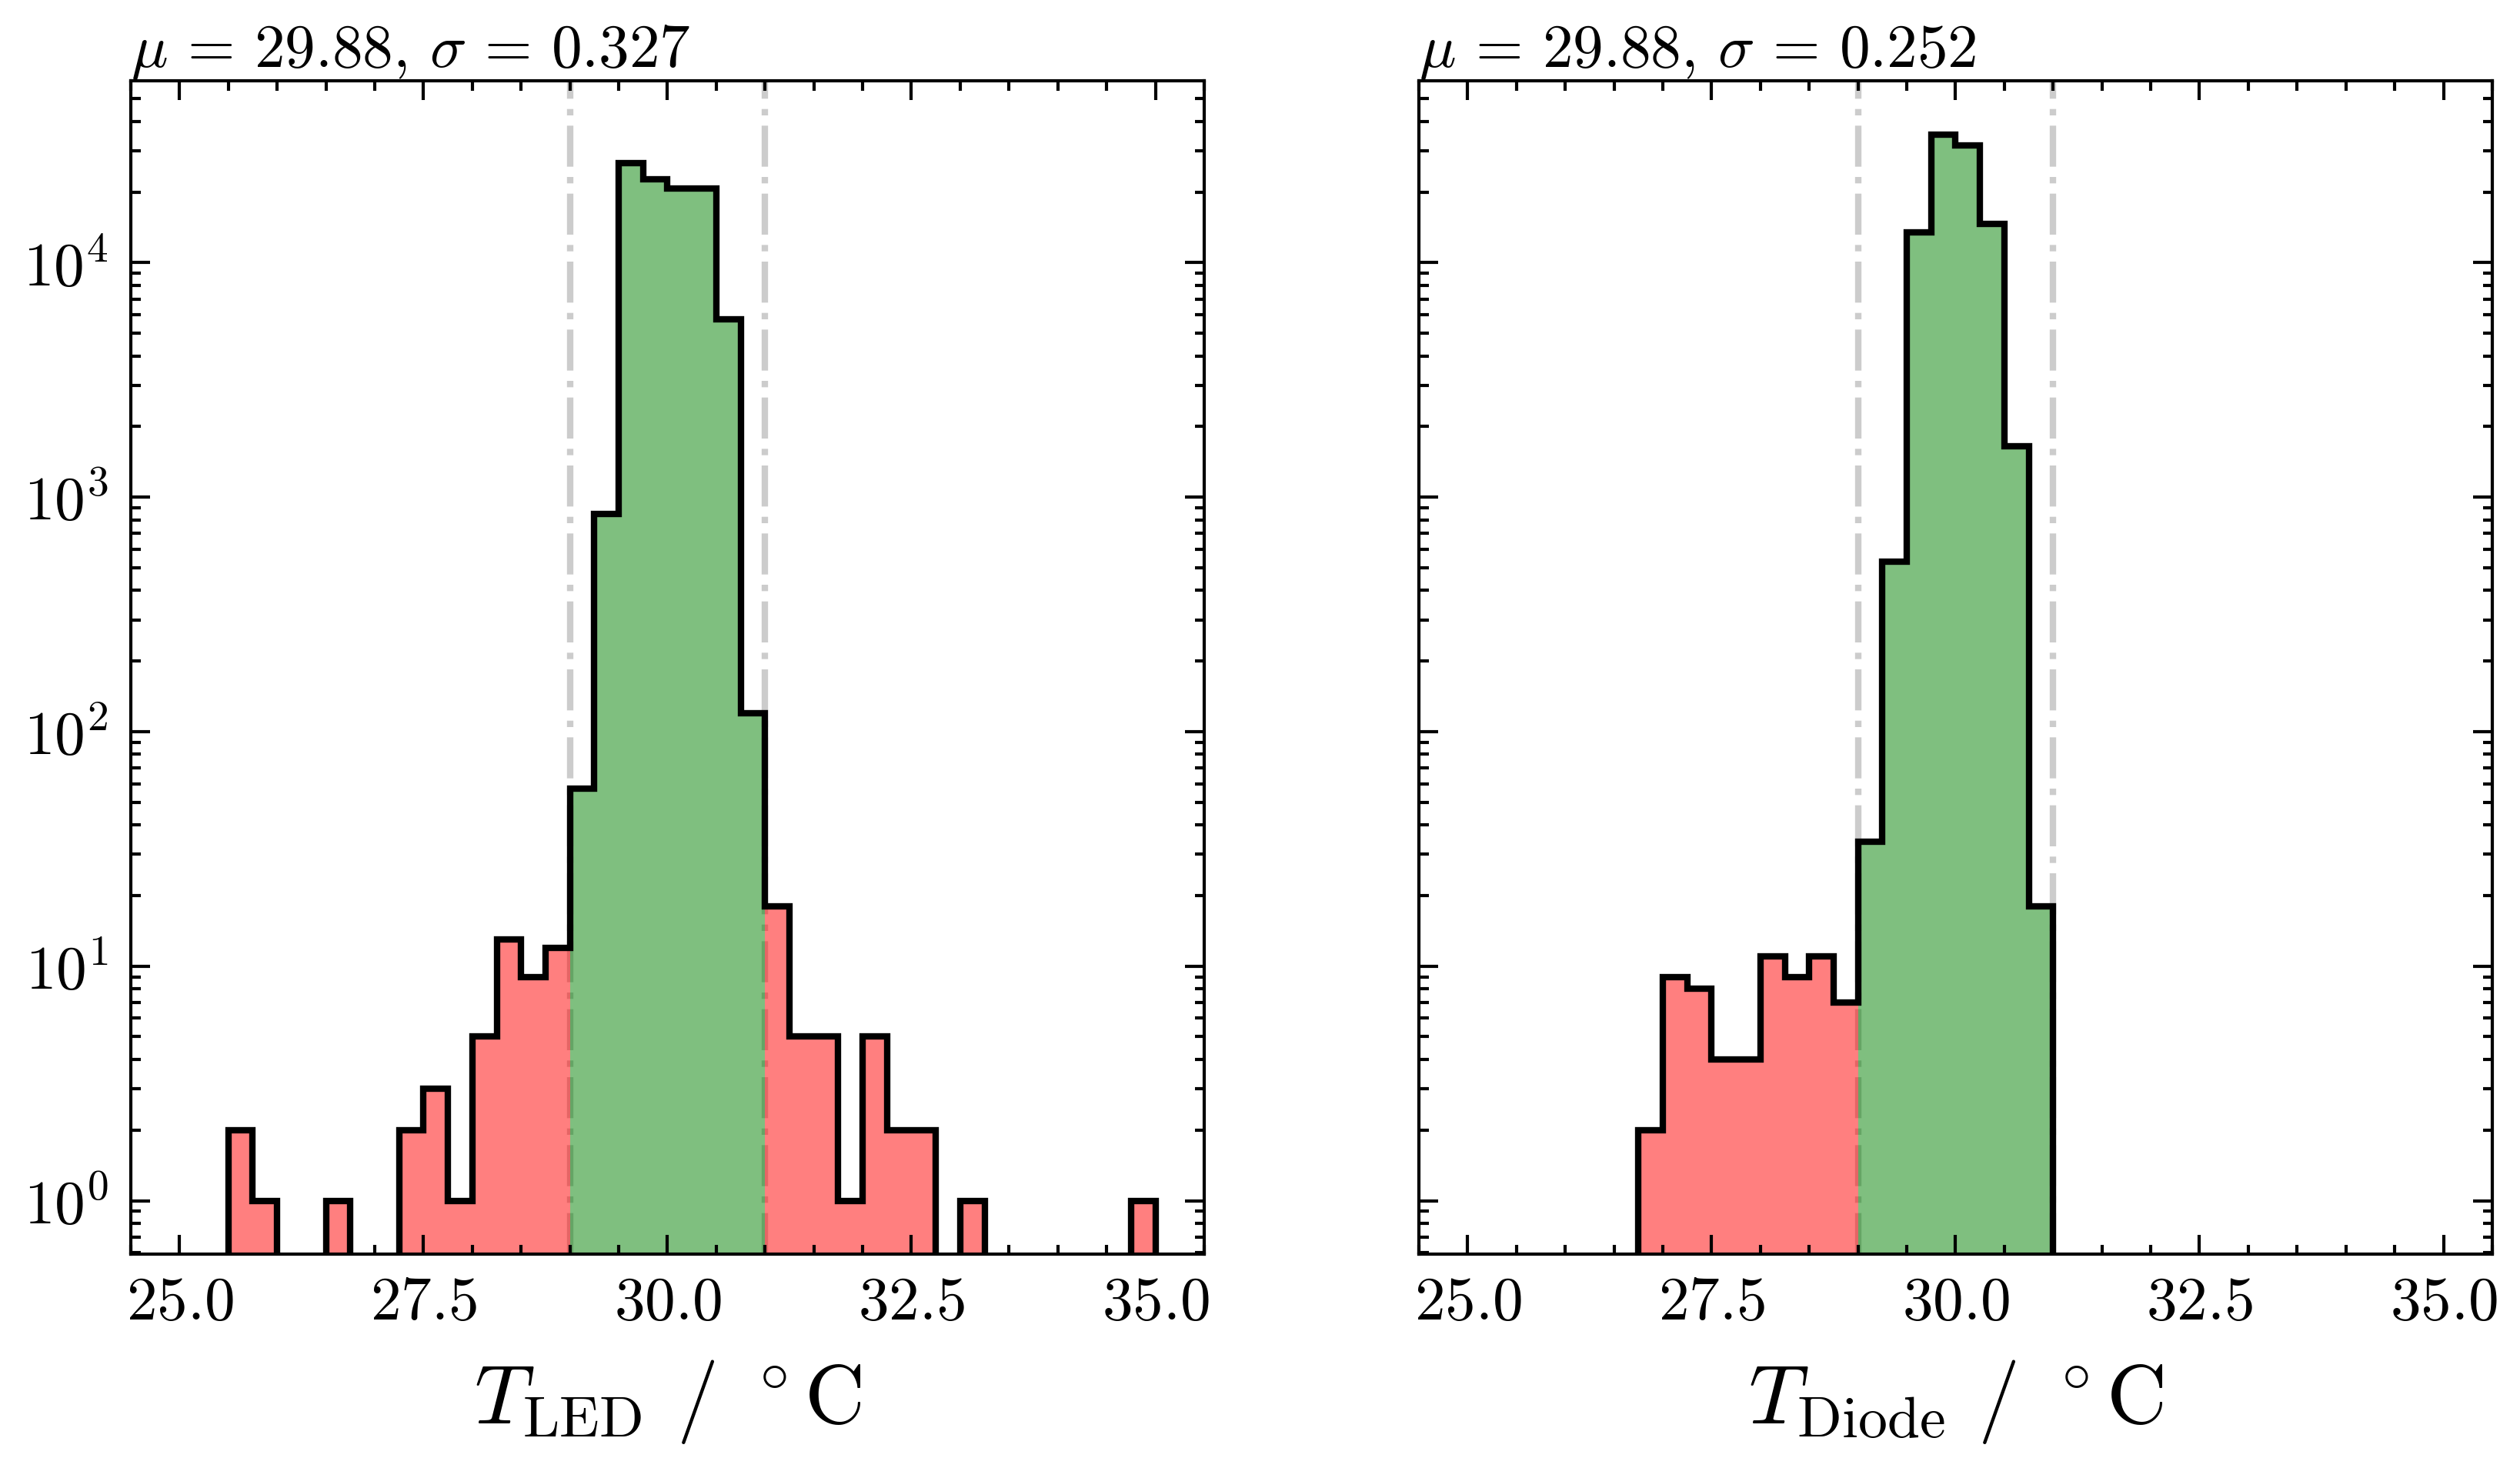

In [4]:
# Temperature

temp_bins = np.linspace(25, 35, 41)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

# _ = ax1.hist(t_led, bins=temp_bins, histtype='step')
_ = select_hist(t_led, temp_bins, [29, 31], ax1, color='k')
ax1.set_yscale('log')
# ax1.set_yticks([])
ax1.set_xlabel('$T_\mathrm{LED}$ / $^\circ$C')
ax1.legend()

# _ = ax2.hist(t_phd, bins=temp_bins, histtype='step')
_ = select_hist(t_phd, temp_bins, [29, 31], ax2, color='k')
ax2.set_yscale('log')
# ax2.set_yticks([])
ax2.set_xlabel('$T_\mathrm{Diode}$ / $^\circ$C')
ax2.legend()

Text(1, 3, 'LM3/LM4 run\nw/ bad config')

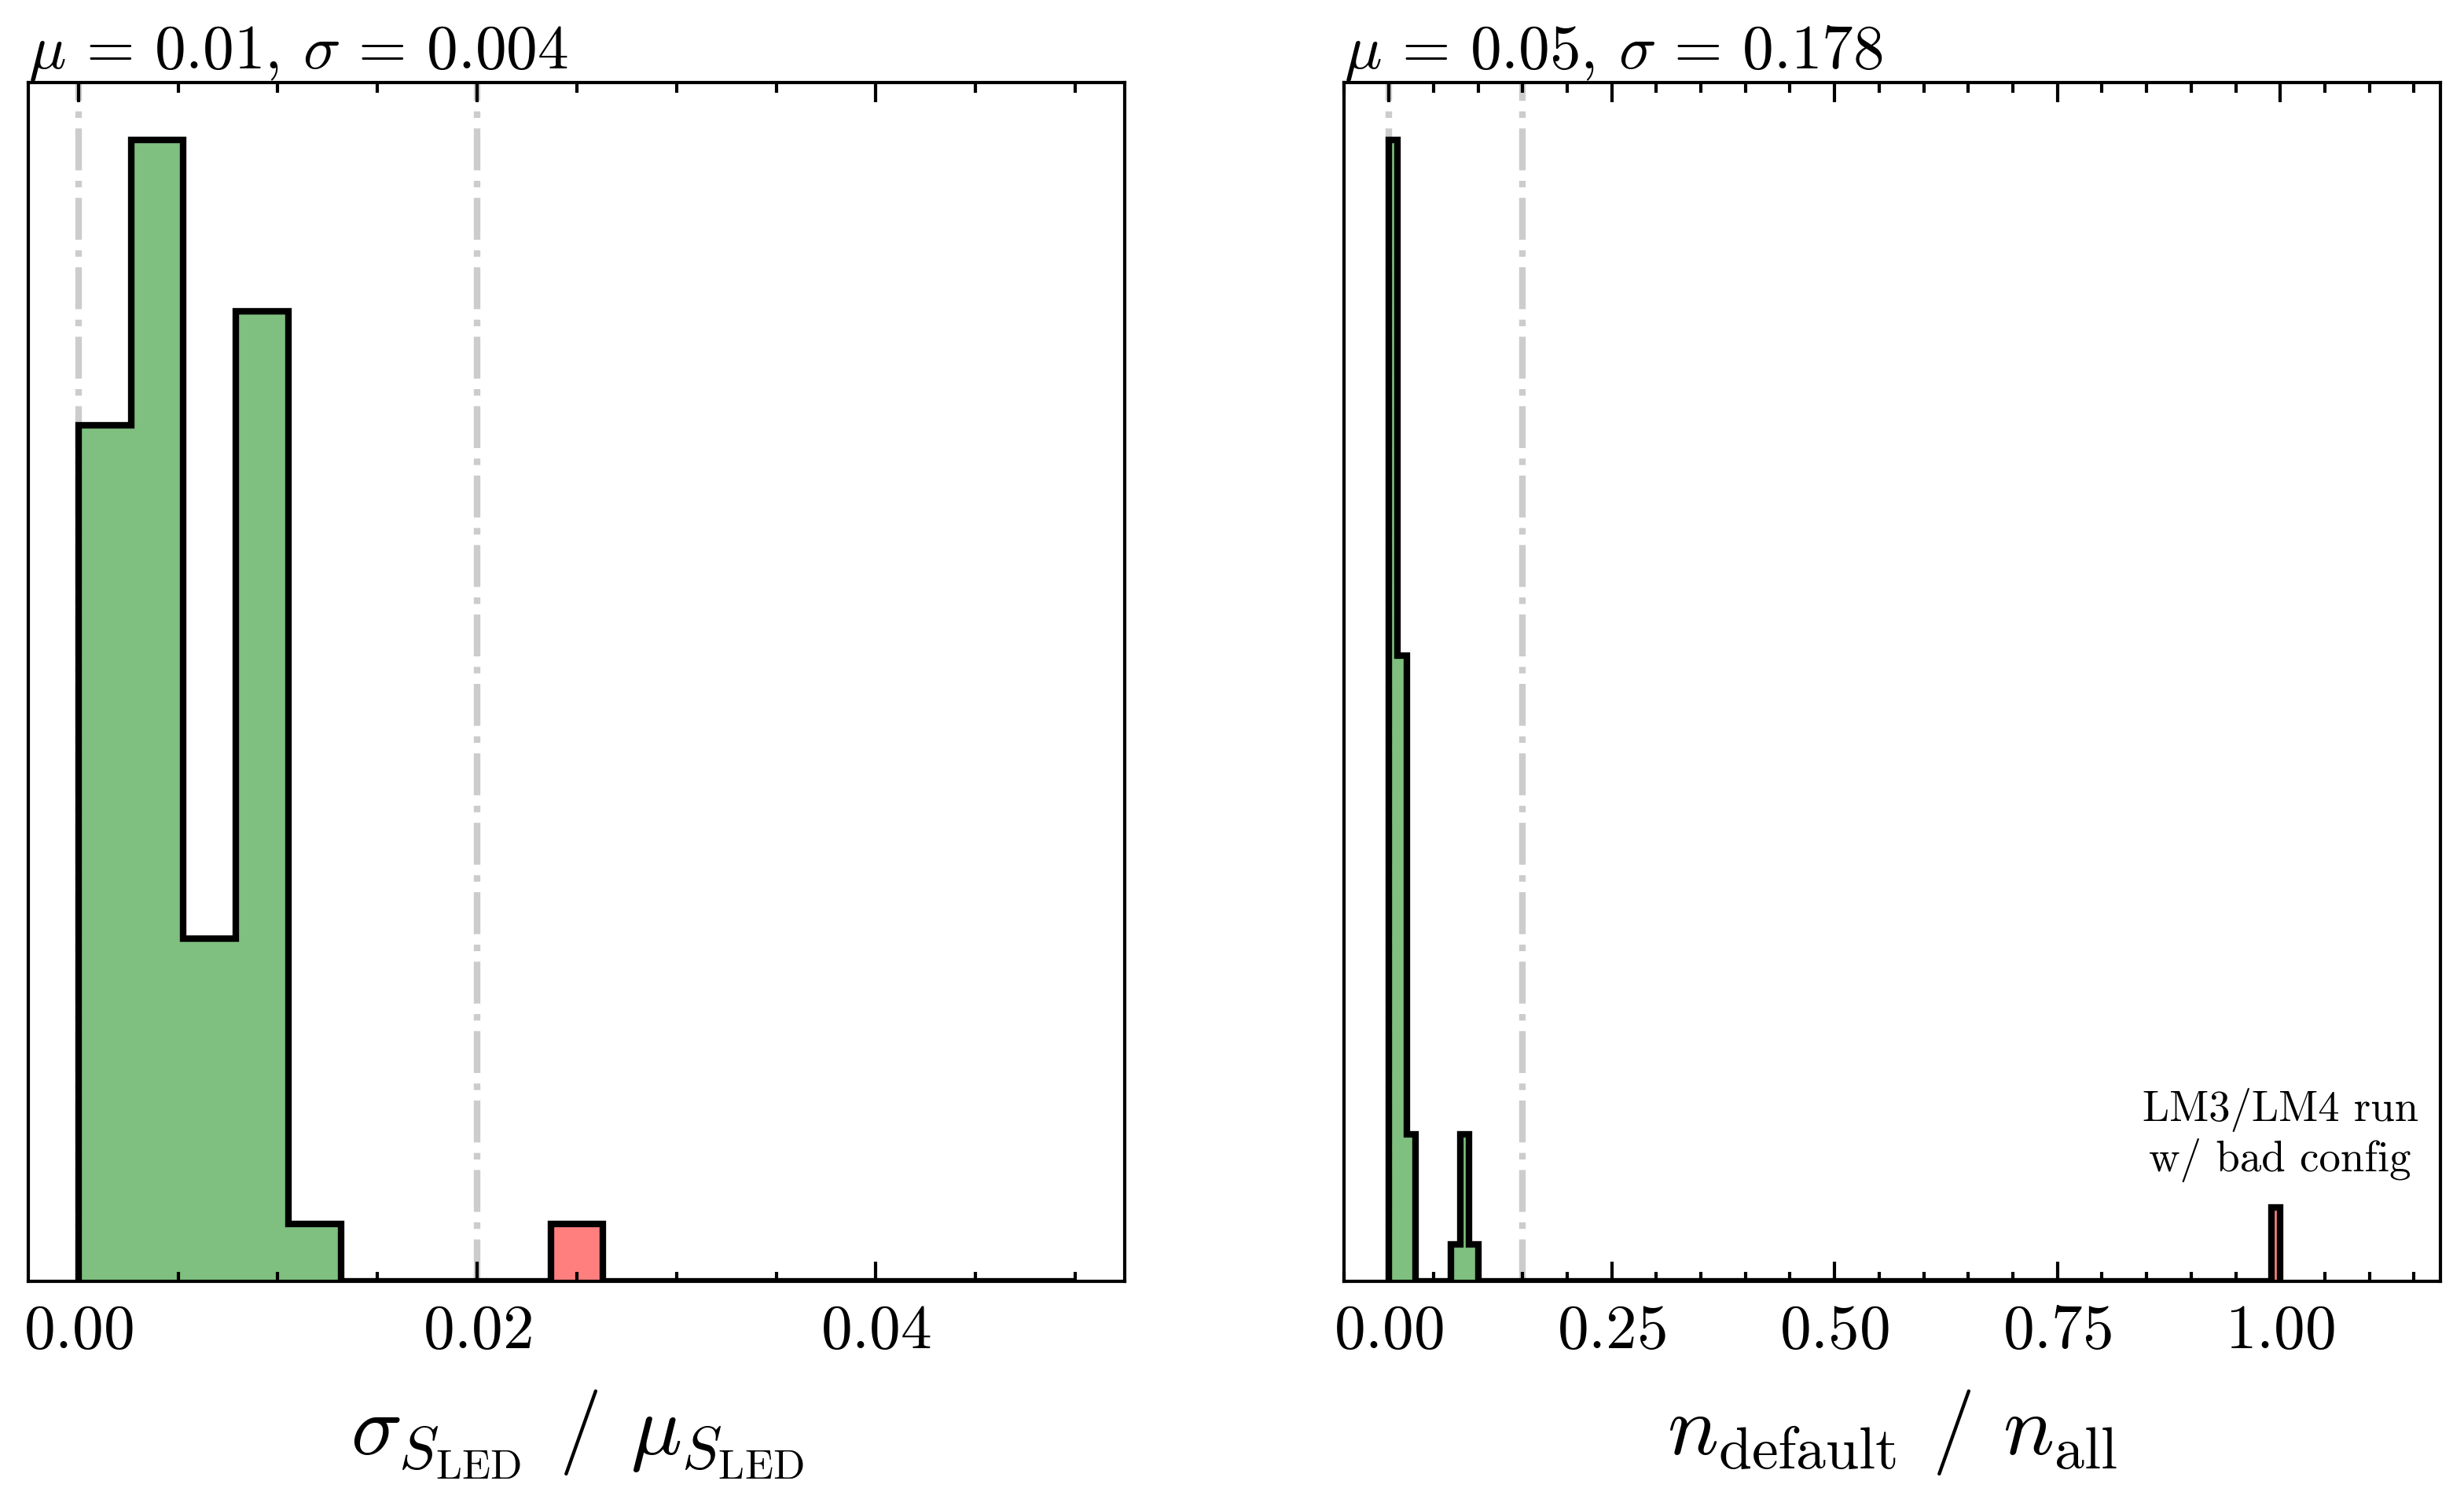

In [5]:
noise_bins = np.linspace(0, 0.05, 20)

fig, (ax1, ax2) = plt.subplots(1, 2)
_ = select_hist(np.array(noise_phd), noise_bins, [0, 0.02], ax1)
ax1.set_xlabel(r"$\sigma_{S_\mathrm{LED}}$ / $\mu_{S_\mathrm{LED}}$")
ax1.set_yticks([])


# missing bins

missing_bins = np.linspace(0, 1, 101)

_ = select_hist(np.array(missing), missing_bins, [0, 0.15], ax2)
ax2.set_xlabel(r"$n_\mathrm{default}$ / $n_\mathrm{all}$")
ax2.set_yticks([])
# plt.xlim(-0.3, 10.3)

ax2.set_xlim(-0.05, 1.18)
ax2.text(1, 3, 'LM3/LM4 run\nw/ bad config', ha='center', size='x-small')


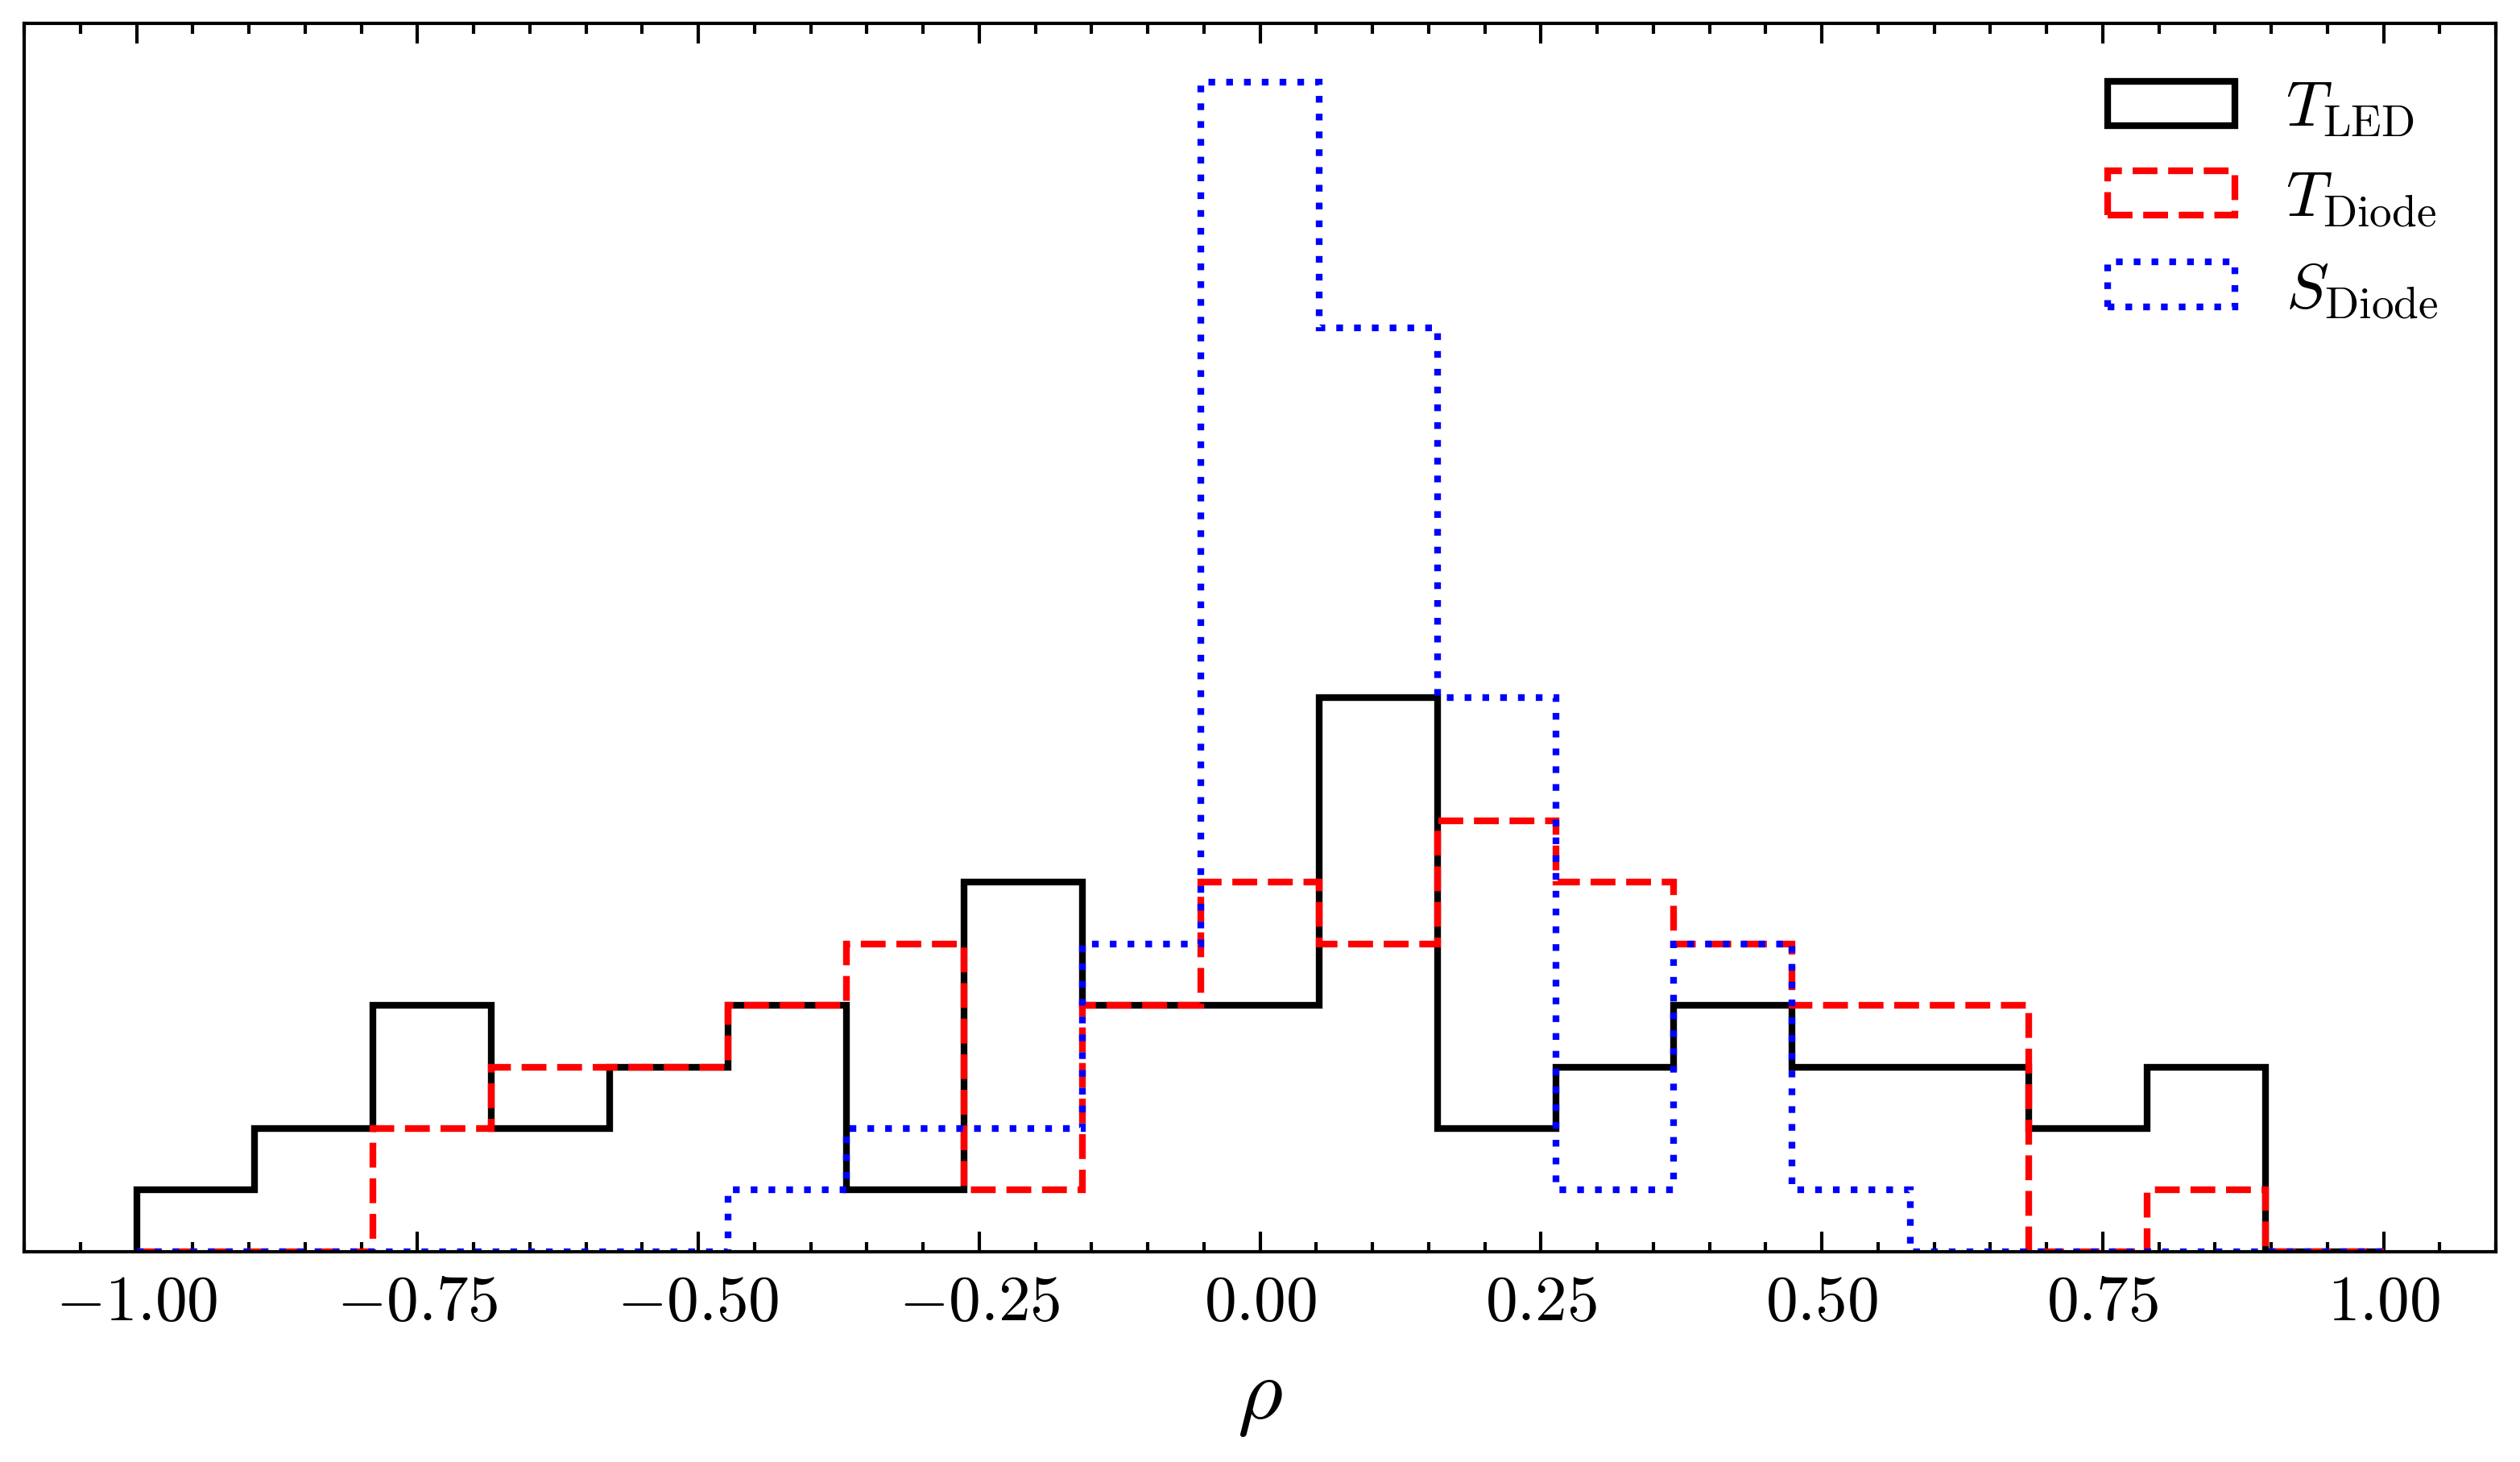

In [6]:
# Drift

drift_bins = np.linspace(-1, 1, 20)

_ = plt.hist(drift_t_led, bins=drift_bins, histtype='step', label=r"$T_\mathrm{LED}$")
_ = plt.hist(drift_t_phd, bins=drift_bins, histtype='step', label=r"$T_\mathrm{Diode}$")
_ = plt.hist(drift_phd, bins=drift_bins, histtype='step', label=r"$S_\mathrm{Diode}$")

plt.xlabel(r'$\rho$')
plt.yticks([])
plt.legend()

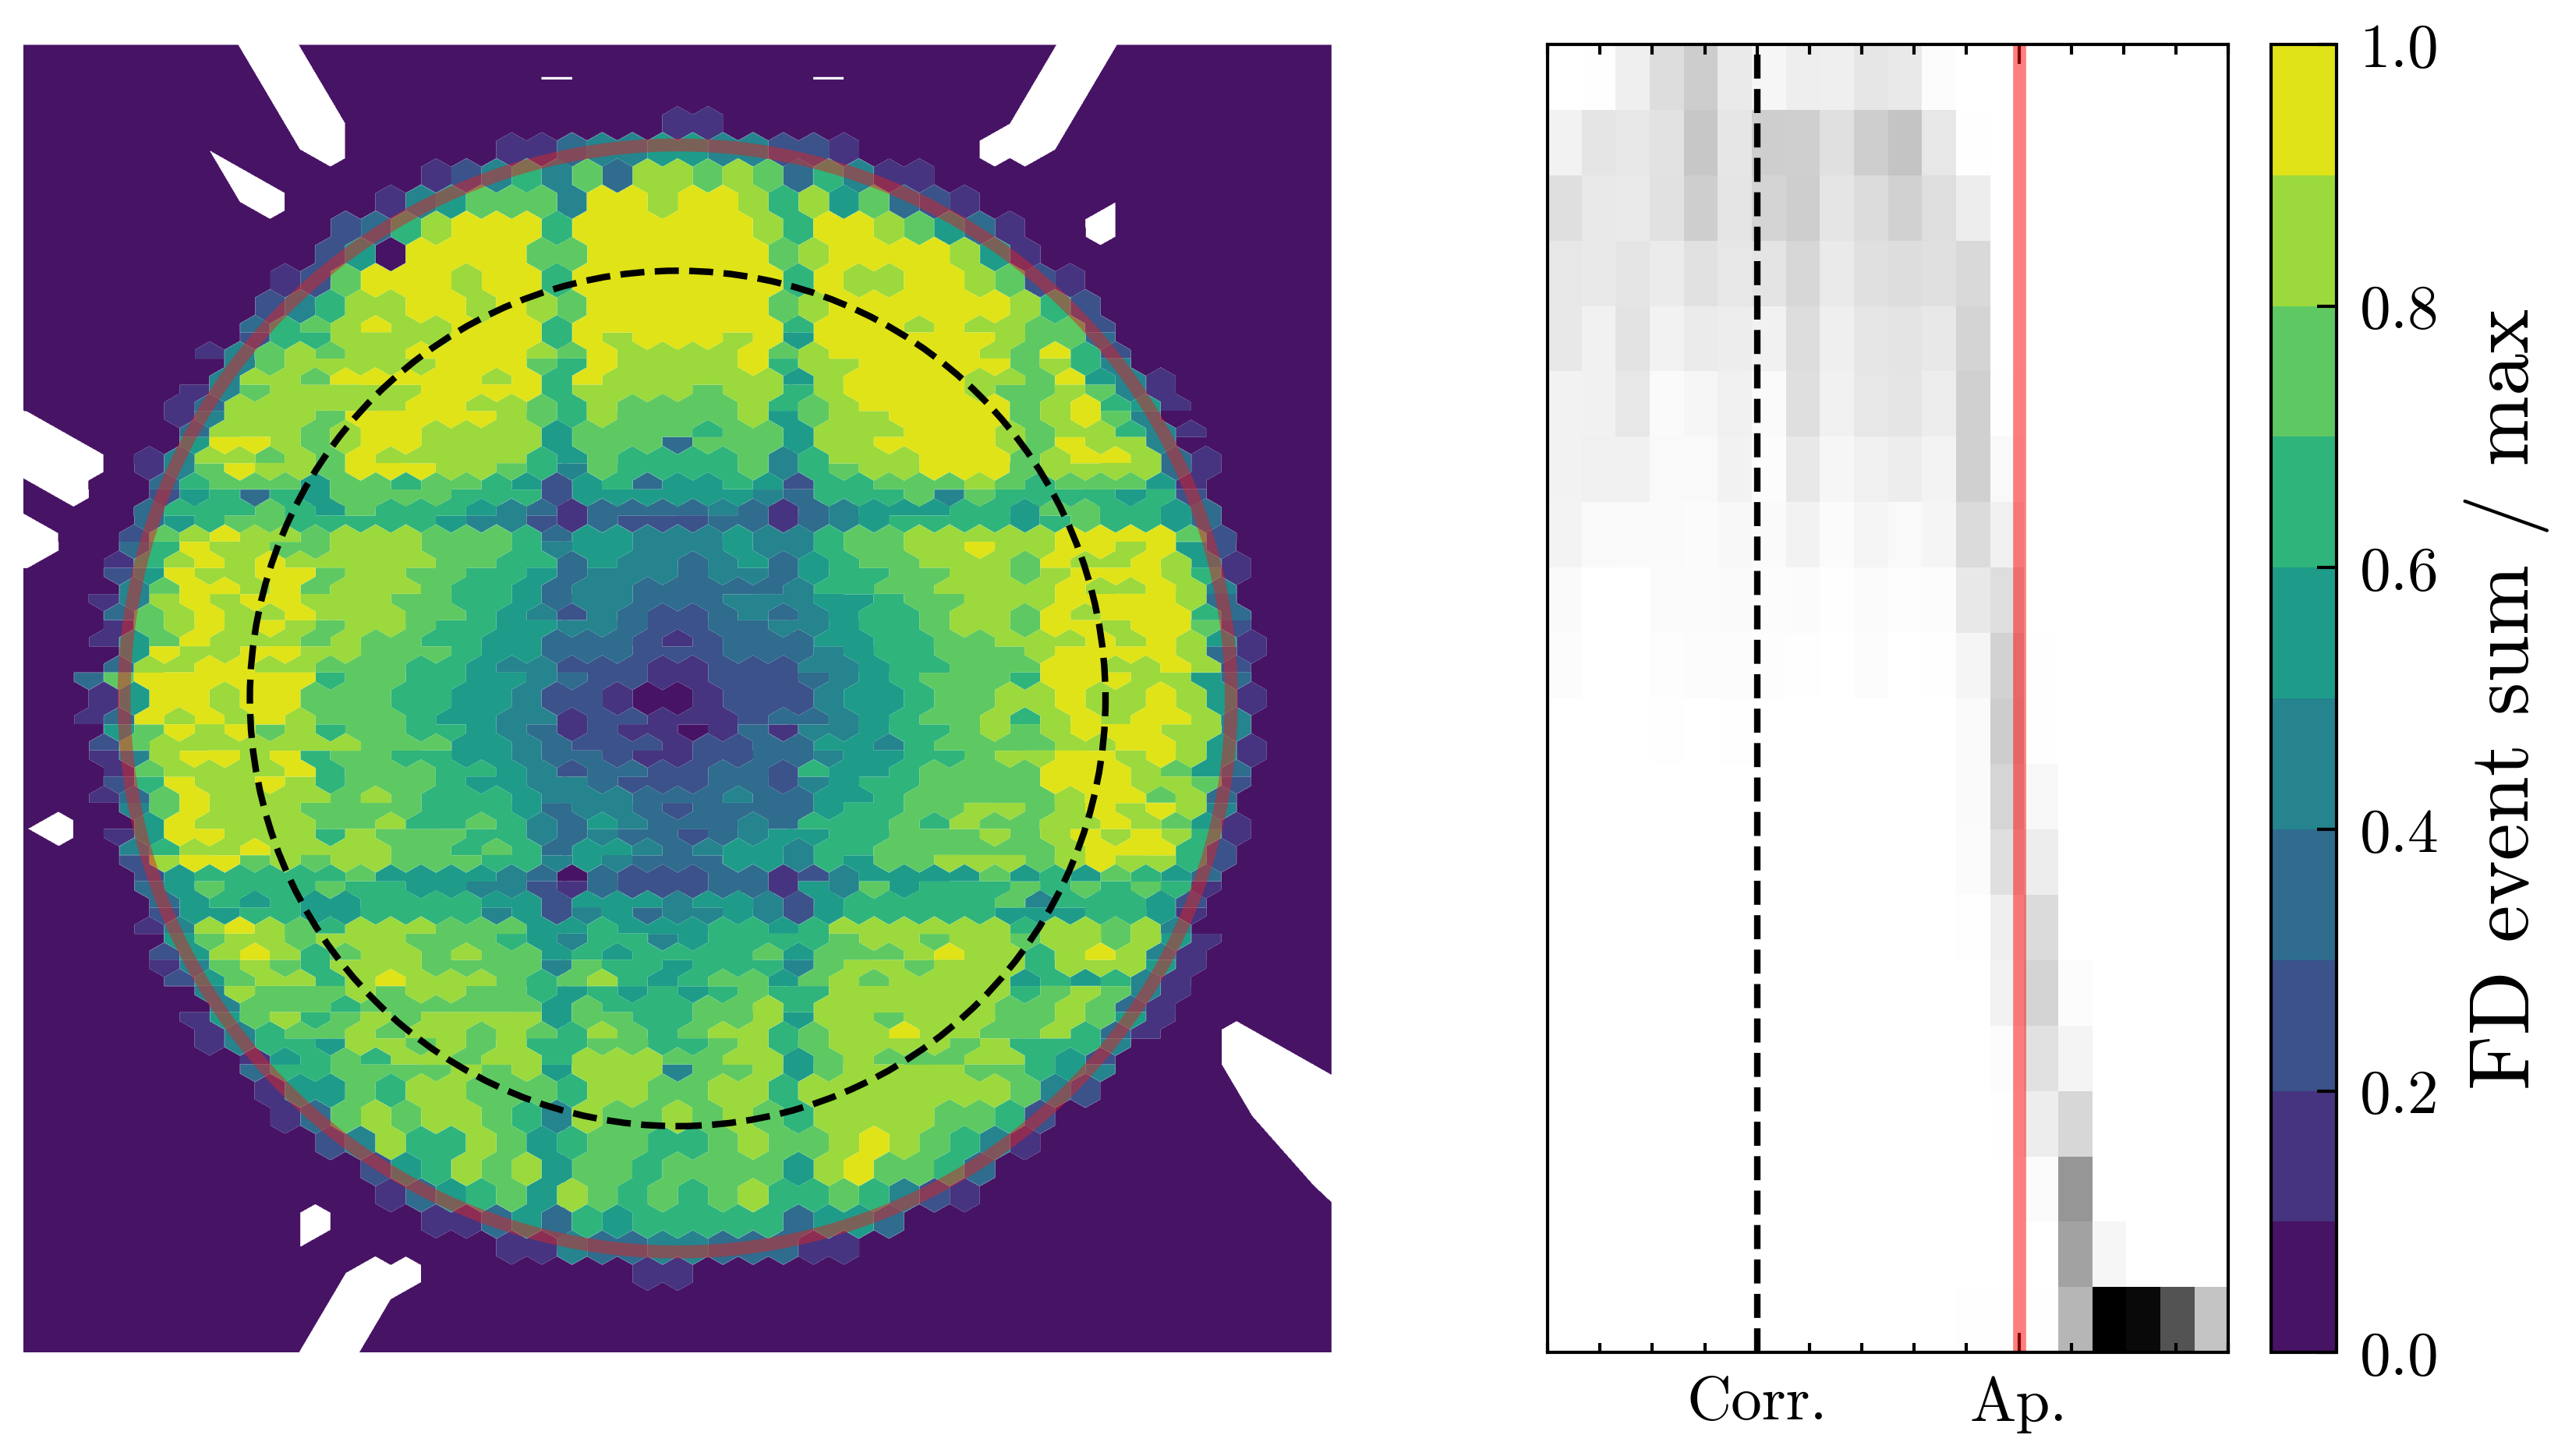

In [12]:
# curtain check

from scipy.interpolate import griddata

fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[1, 0.4])

xii = yii = np.arange(-1300,1300,1)
xi,yi = np.meshgrid(xii,yii)
zi = griddata((x,y),s,(xi,yi),method='nearest', rescale=True)

AddApertureEtcToPlot(ax1)
contour = ax1.contourf(xi,yi,zi, np.linspace(0, 1, 11, endpoint=True), antialiased=True)

_ = ax2.hist2d(np.sqrt(np.array(x)**2 + np.array(y)**2), s, bins=[20, 20], 
               range=([650, 1300], [0, 1]), norm='symlog', cmap='binary')
# data, _, _ = np.histogram2d(np.sqrt(np.array(x)**2 + np.array(y)**2), s, 
#                          bins=[20, 20], range=([500, 1300], [0, 1]))
# ax2.imshow(data, origin='lower', extent=(500, 1300, 0, 1), aspect='auto', norm='symlog')
plt.colorbar(contour, ax=ax2, label='FD event sum / max')
ax2.axvline(1100, c='r', lw=2, alpha = 0.5)
ax2.axvline(850, c='k', ls='--')
# ax2.set_xlim(1080)
ax2.set_yticks([])
ax2.set_xticks([850, 1100], ['Corr.', 'Ap.'])
ax1.axis('off')
# ax2.set_xscale('log')

plt.subplots_adjust(wspace=0)
plt.tight_layout()

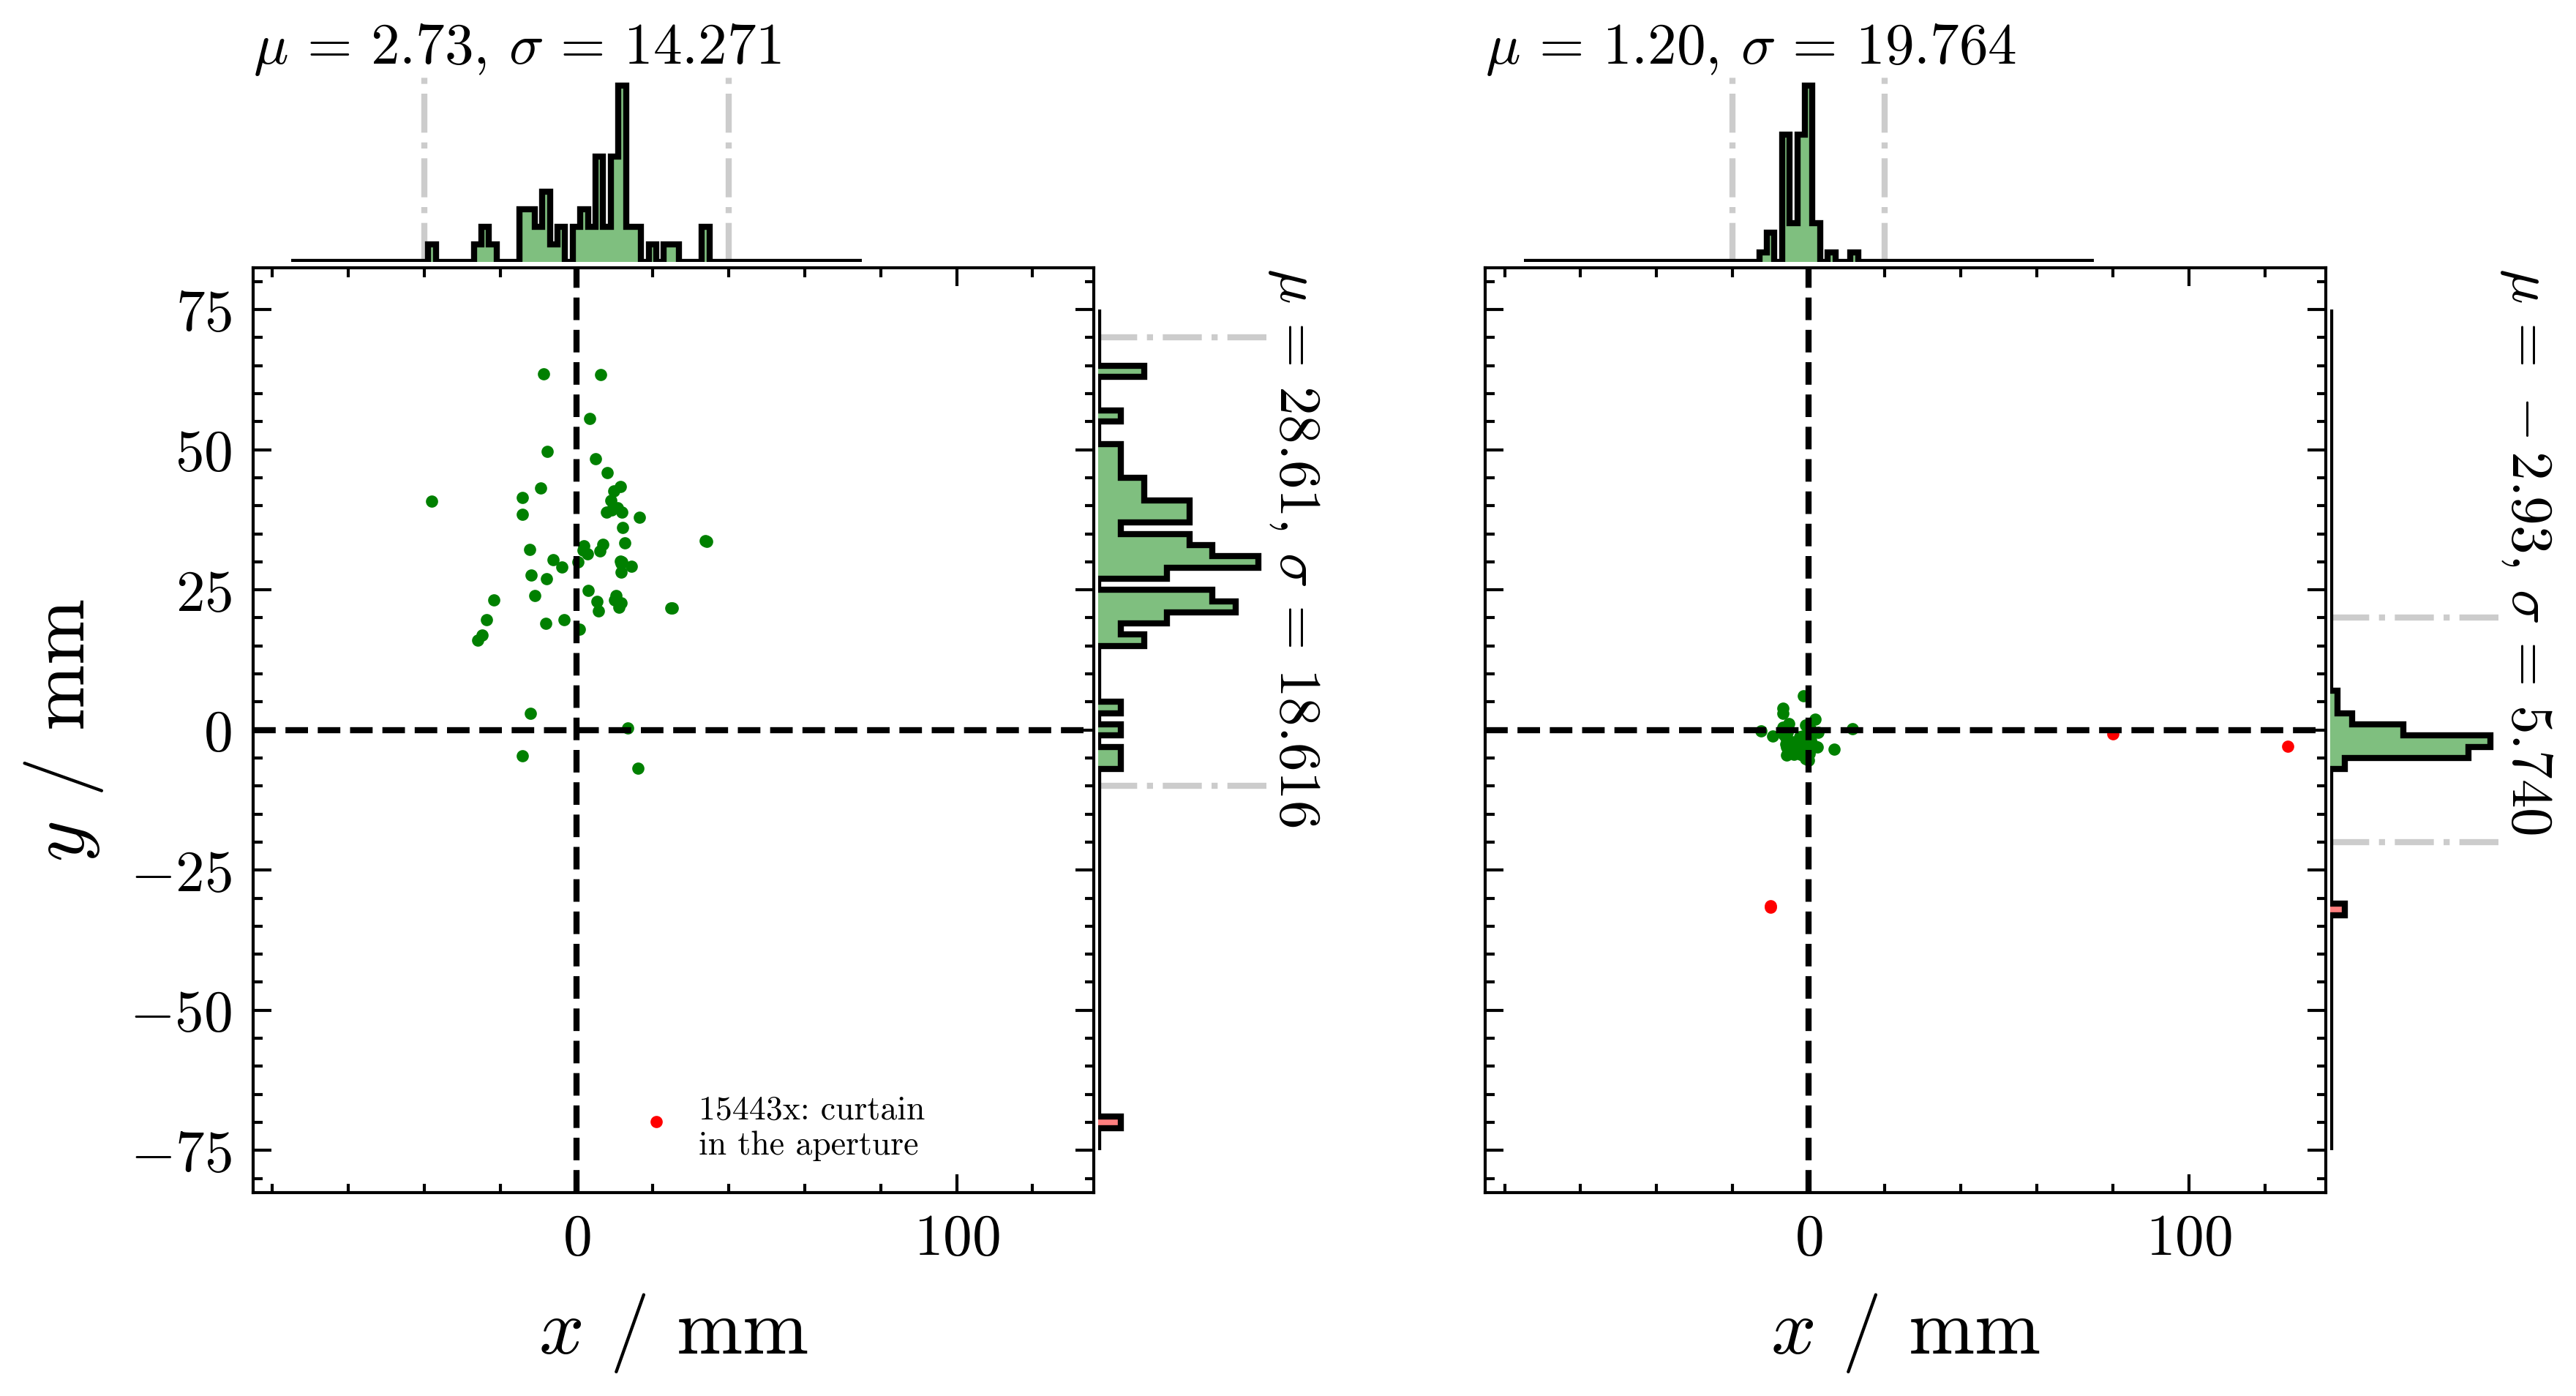

In [21]:
# anisotropy

ani_bins = np.arange(-75, 76, 2)

fig = plt.figure()

gs = GridSpec(
    2, 5,
    width_ratios=[1, 0.2, 0.25, 1, 0.2],
    height_ratios=[0.2, 1],
)

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1)

ax4 = fig.add_subplot(gs[1, 3], sharex=ax1, sharey=ax1)
ax5 = fig.add_subplot(gs[0, 3], sharex=ax4)
ax6 = fig.add_subplot(gs[1, 4], sharey=ax4)

ax2.axis('off')
ax3.axis('off')
ax5.axis('off')
ax6.axis('off')

sel_x = select_hist(mean_x, ani_bins, [-40, 40], ax2, c='k')
sel_y = select_hist(mean_y, ani_bins, [-10, 70], ax3, c='k', orientation='horizontal')
select_mask = sel_x & sel_y

ax1.scatter(np.array(mean_x)[~select_mask], np.array(mean_y)[~select_mask], c='r', s=1)
ax1.scatter(np.array(mean_x)[select_mask], np.array(mean_y)[select_mask], c='g', s=1)
ax1.axvline(0, c='k', ls='--')
ax1.axhline(0, c='k', ls='--')
ax1.set_xlabel('$x$ / mm')
ax1.set_ylabel('$y$ / mm')

ax1.text(0.53, 0.07, "15443x: curtain\nin the aperture",
         ha='left', va='center', transform=ax1.transAxes,
         fontsize='xx-small', fontdict={'fontweight': 'bold'})


sel_x = select_hist(filter_x, ani_bins, [-20, 20], ax5, c='k')
sel_y = select_hist(filter_y, ani_bins, [-20, 20], ax6, c='k', orientation='horizontal')
select_mask = sel_x & sel_y

ax4.scatter(np.array(filter_x)[~select_mask], np.array(filter_y)[~select_mask], c='r', s=1)
ax4.scatter(np.array(filter_x)[select_mask], np.array(filter_y)[select_mask], c='g', s=1)
ax4.axvline(0, c='k', ls='--')
ax4.axhline(0, c='k', ls='--')
ax4.set_xlabel('$x$ / mm')

# ax4.set_ylabel('y / mm')

plt.setp(ax4.get_yticklabels(), visible=False, fontsize=0)
plt.subplots_adjust(hspace=0.01, wspace=0.01)

# fig, ax = plt.subplots()

# filter_x, filter_y = np.array(filter_x), np.array(filter_y)
# mean, mean_y = np.array(mean_x), np.array(mean_y)

# _ = select_hist(np.sqrt((filter_x - mean_x)**2 + (filter_y - mean_y)**2), np.linspace(0, 200, 40), [0, 80], ax)



Text(0.92, 0.11, '12307x\nat LA5')

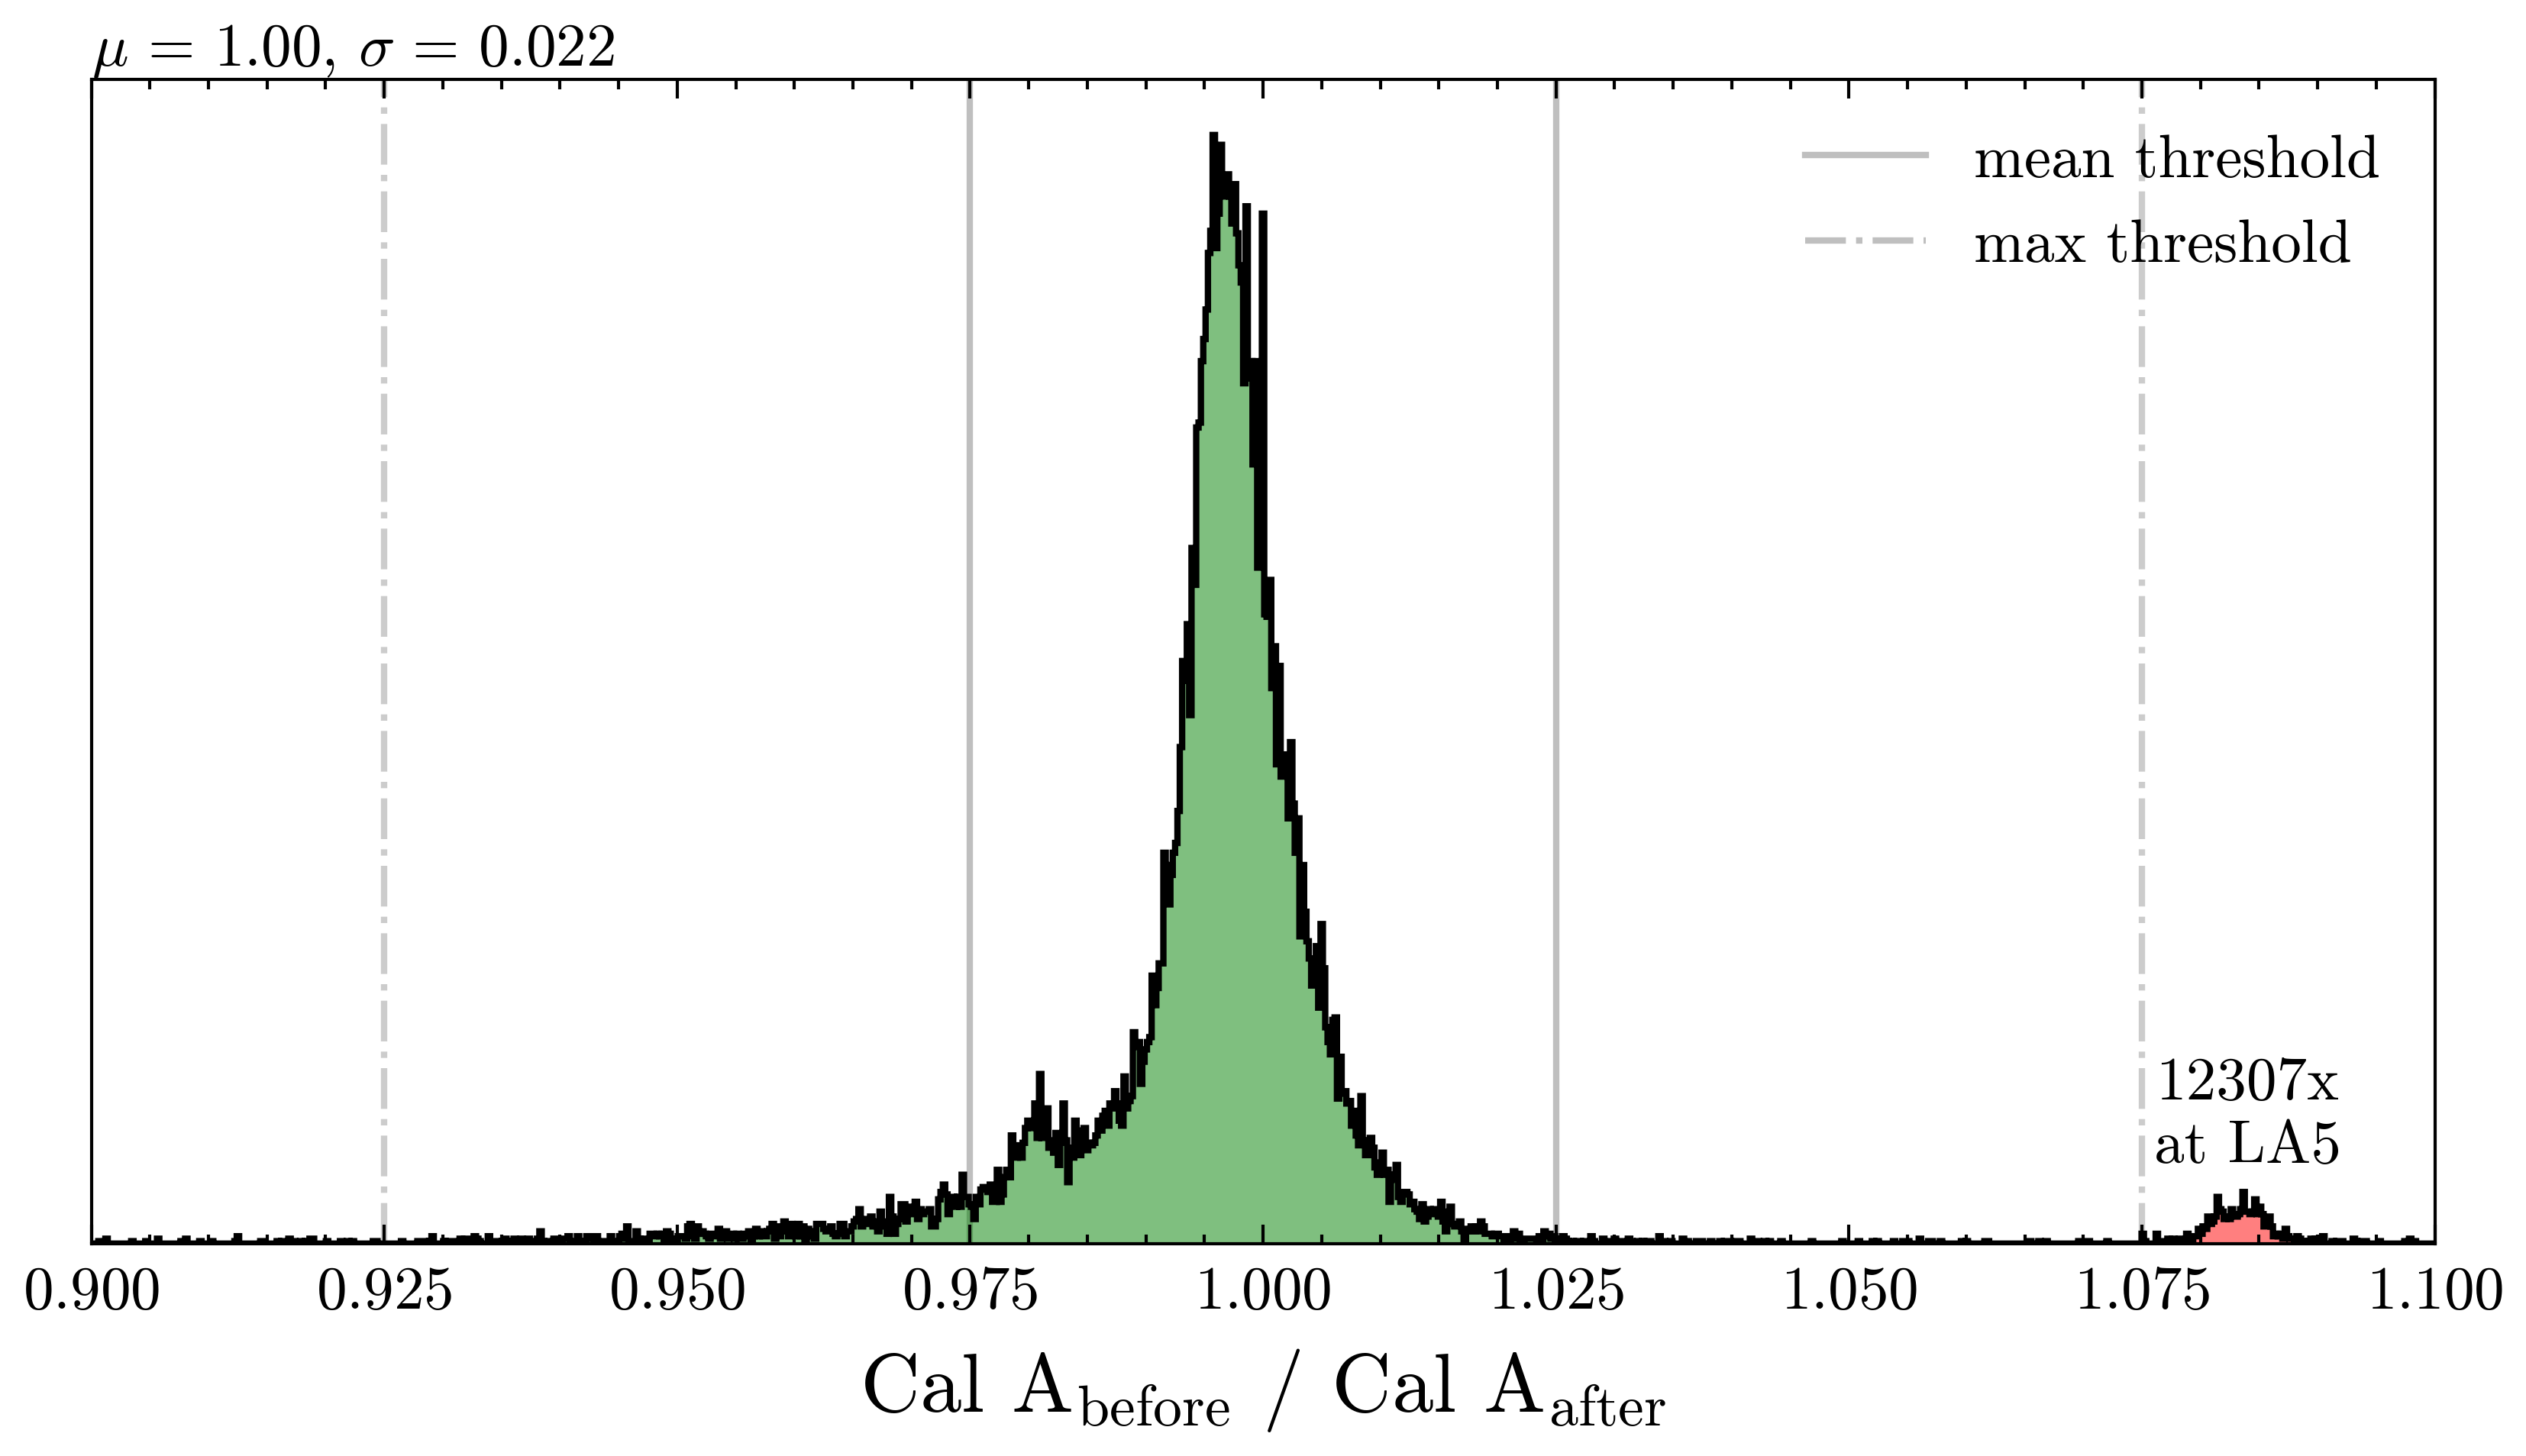

In [29]:
# cal a stability

cal_a_bins = np.linspace(0.9, 1.1, 1000)
cal_a_mean = np.linspace(0.9, 1.1, 100)

cal_a_ratios = np.array(cal_a_ratios)
cal_a_ratios[cal_a_ratios < 0] = np.nan

cal_a_ratios[~np.isfinite(cal_a_ratios)] = 1

_ = select_hist(cal_a_ratios, bins=cal_a_bins, cuts=[0.925, 1.075], ax=plt.gca())
plt.xlabel(r'Cal A$_\mathrm{before}$ / Cal A$_\mathrm{after}$')
plt.yticks([])

plt.axvline(0.975, c='gray', ls='solid', label='mean threshold', zorder=0, alpha=0.5)
plt.axvline(1.025, c='gray', ls='solid', zorder=0, alpha=0.5)

plt.axvline(1.2, c='gray', ls='-.', label='max threshold', alpha=0.5)
plt.xlim(0.9, 1.1)
plt.legend()

plt.text(0.92, 0.11, "12307x\nat LA5",
         va='center', ha='center', transform=plt.gca().transAxes)


/tmp/ipykernel_4476/2360885549.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


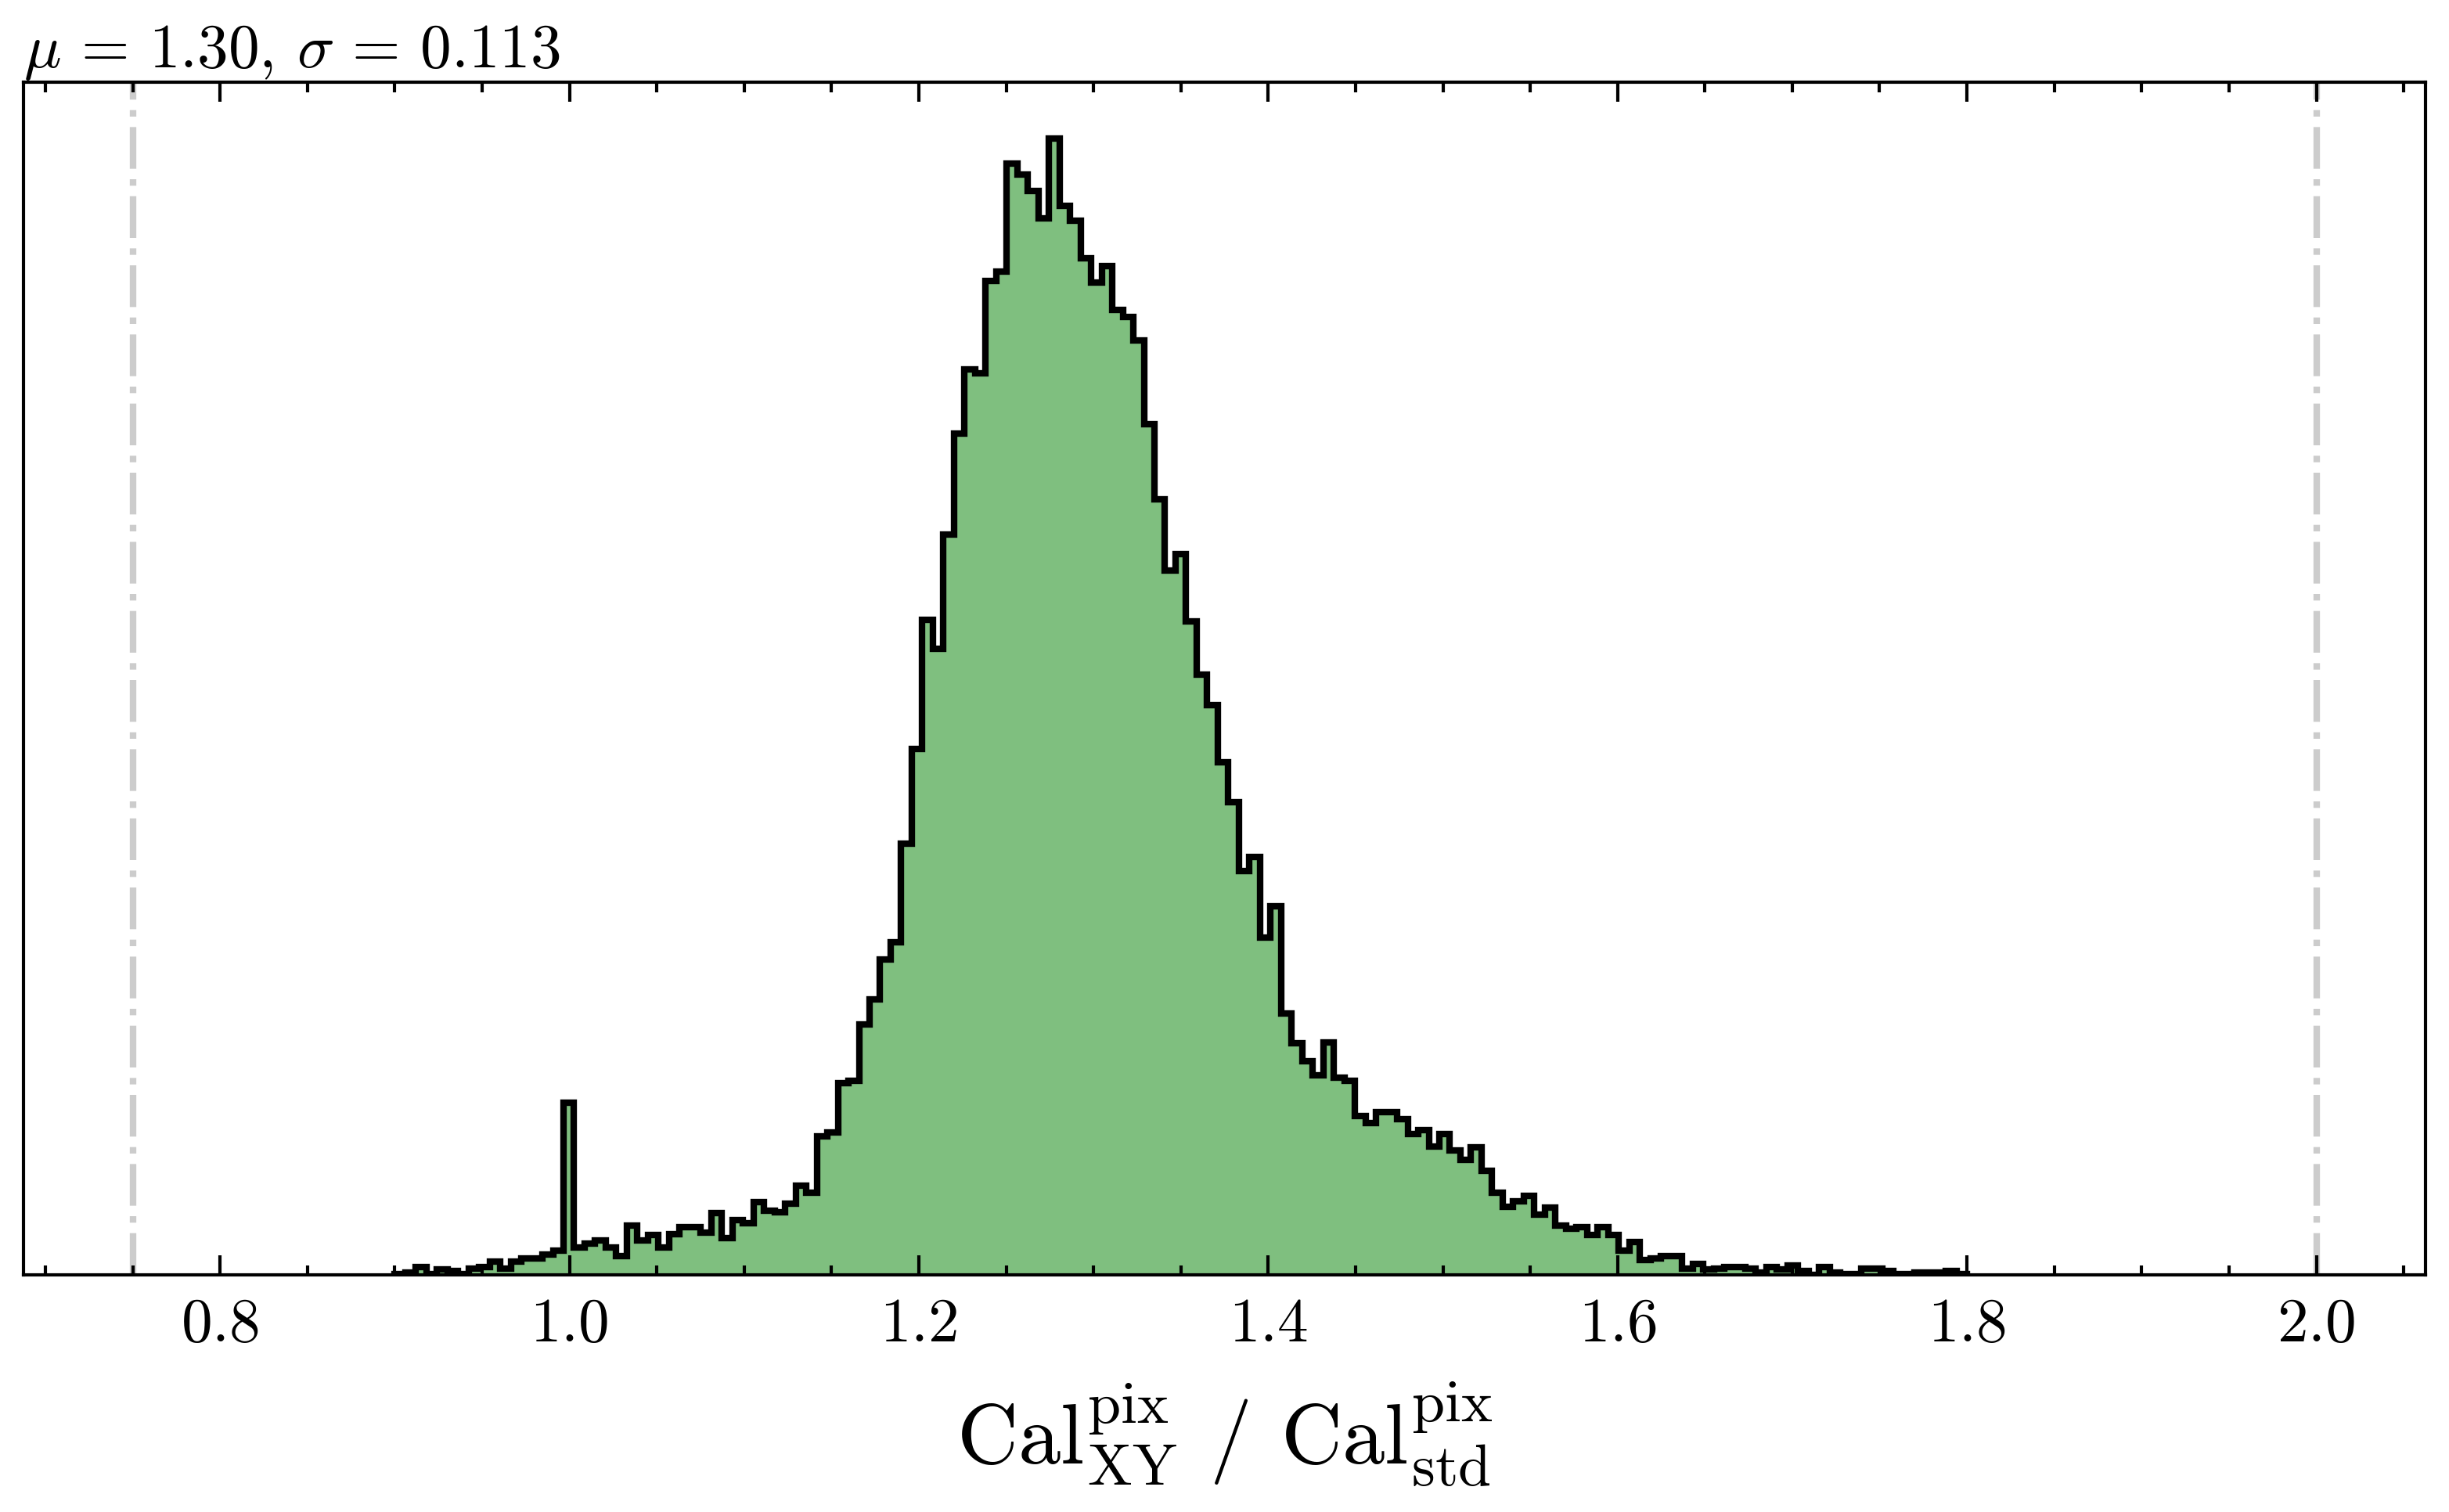

In [10]:
# std. calib

std_calib_bins = np.linspace(0.9, 1.8, 150)

std_calib_ratios = np.array(std_calib_ratios)
std_calib_ratios[~np.isfinite(std_calib_ratios)] = 1
colors = ['#e1efaf', '#3469ff', '#ffff00', '#319c31', '#d13232']
# colors = ['w' for _ in range(6)]

# for telescope, runs in tel_std_calib_ratios.items():
#     _ = plt.hist(runs, bins=std_calib_bins, histtype='step', label=telescope)
# plt.xlabel(r'Cal$^\mathrm{pix}_\mathrm{XY}$ / Cal$^\mathrm{pix}_\mathrm{std}$')
# _ = plt.hist(tel_std_calib_ratios.values(), bins=std_calib_bins, 
#              histtype='barstacked', label=list(tel_std_calib_ratios.keys()),
#              color=colors, edgecolor='k', lw=0.05, hatch=['/', '-', '\\', '|', '+'])

# for i, (c, x) in enumerate(zip(colors, tel_std_calib_ratios.values())):
#     x = np.array(x)[np.isfinite(x)]
#     plt.text(0.01, 1 - i/14,
#         rf'$\mu\,=\,{np.nanmean(x):.2f}$, $\sigma\,=\,{np.nanstd(x):.3f}$',
#         transform=plt.gca().transAxes,
#         fontsize='small',
#         color=c
#     )
# std_calib_ratios = np.array(std_calib_ratios)[np.isfinite(std_calib_ratios)]
# plt.text(0, 1, 
#             rf"$\mu\,=\,{np.nanmean(std_calib_ratios):.2f}$, $\sigma\,=\,{np.nanstd(std_calib_ratios):.3f}$",
#             transform=plt.gca().transAxes,
#             ha='left',
#             va='bottom')

# _ = plt.hist(tel_std_calib_ratios['HEAT post cleaning'], bins=std_calib_bins,
#              histtype='step', label='HEAT')
# plt.yticks([])
# plt.legend()

plt.figure()
_ = select_hist(std_calib_ratios, bins=std_calib_bins, cuts=[0.75, 2])
plt.xlabel(r'Cal$^\mathrm{pix}_\mathrm{XY}$ / Cal$^\mathrm{pix}_\mathrm{std}$')
plt.yticks([])
plt.legend()



/tmp/ipykernel_4476/1799341510.py:24: RuntimeWarning: invalid value encountered in subtract
  y = (y - y[last]) / y[last]


(-69852636.0, 3326316.0)

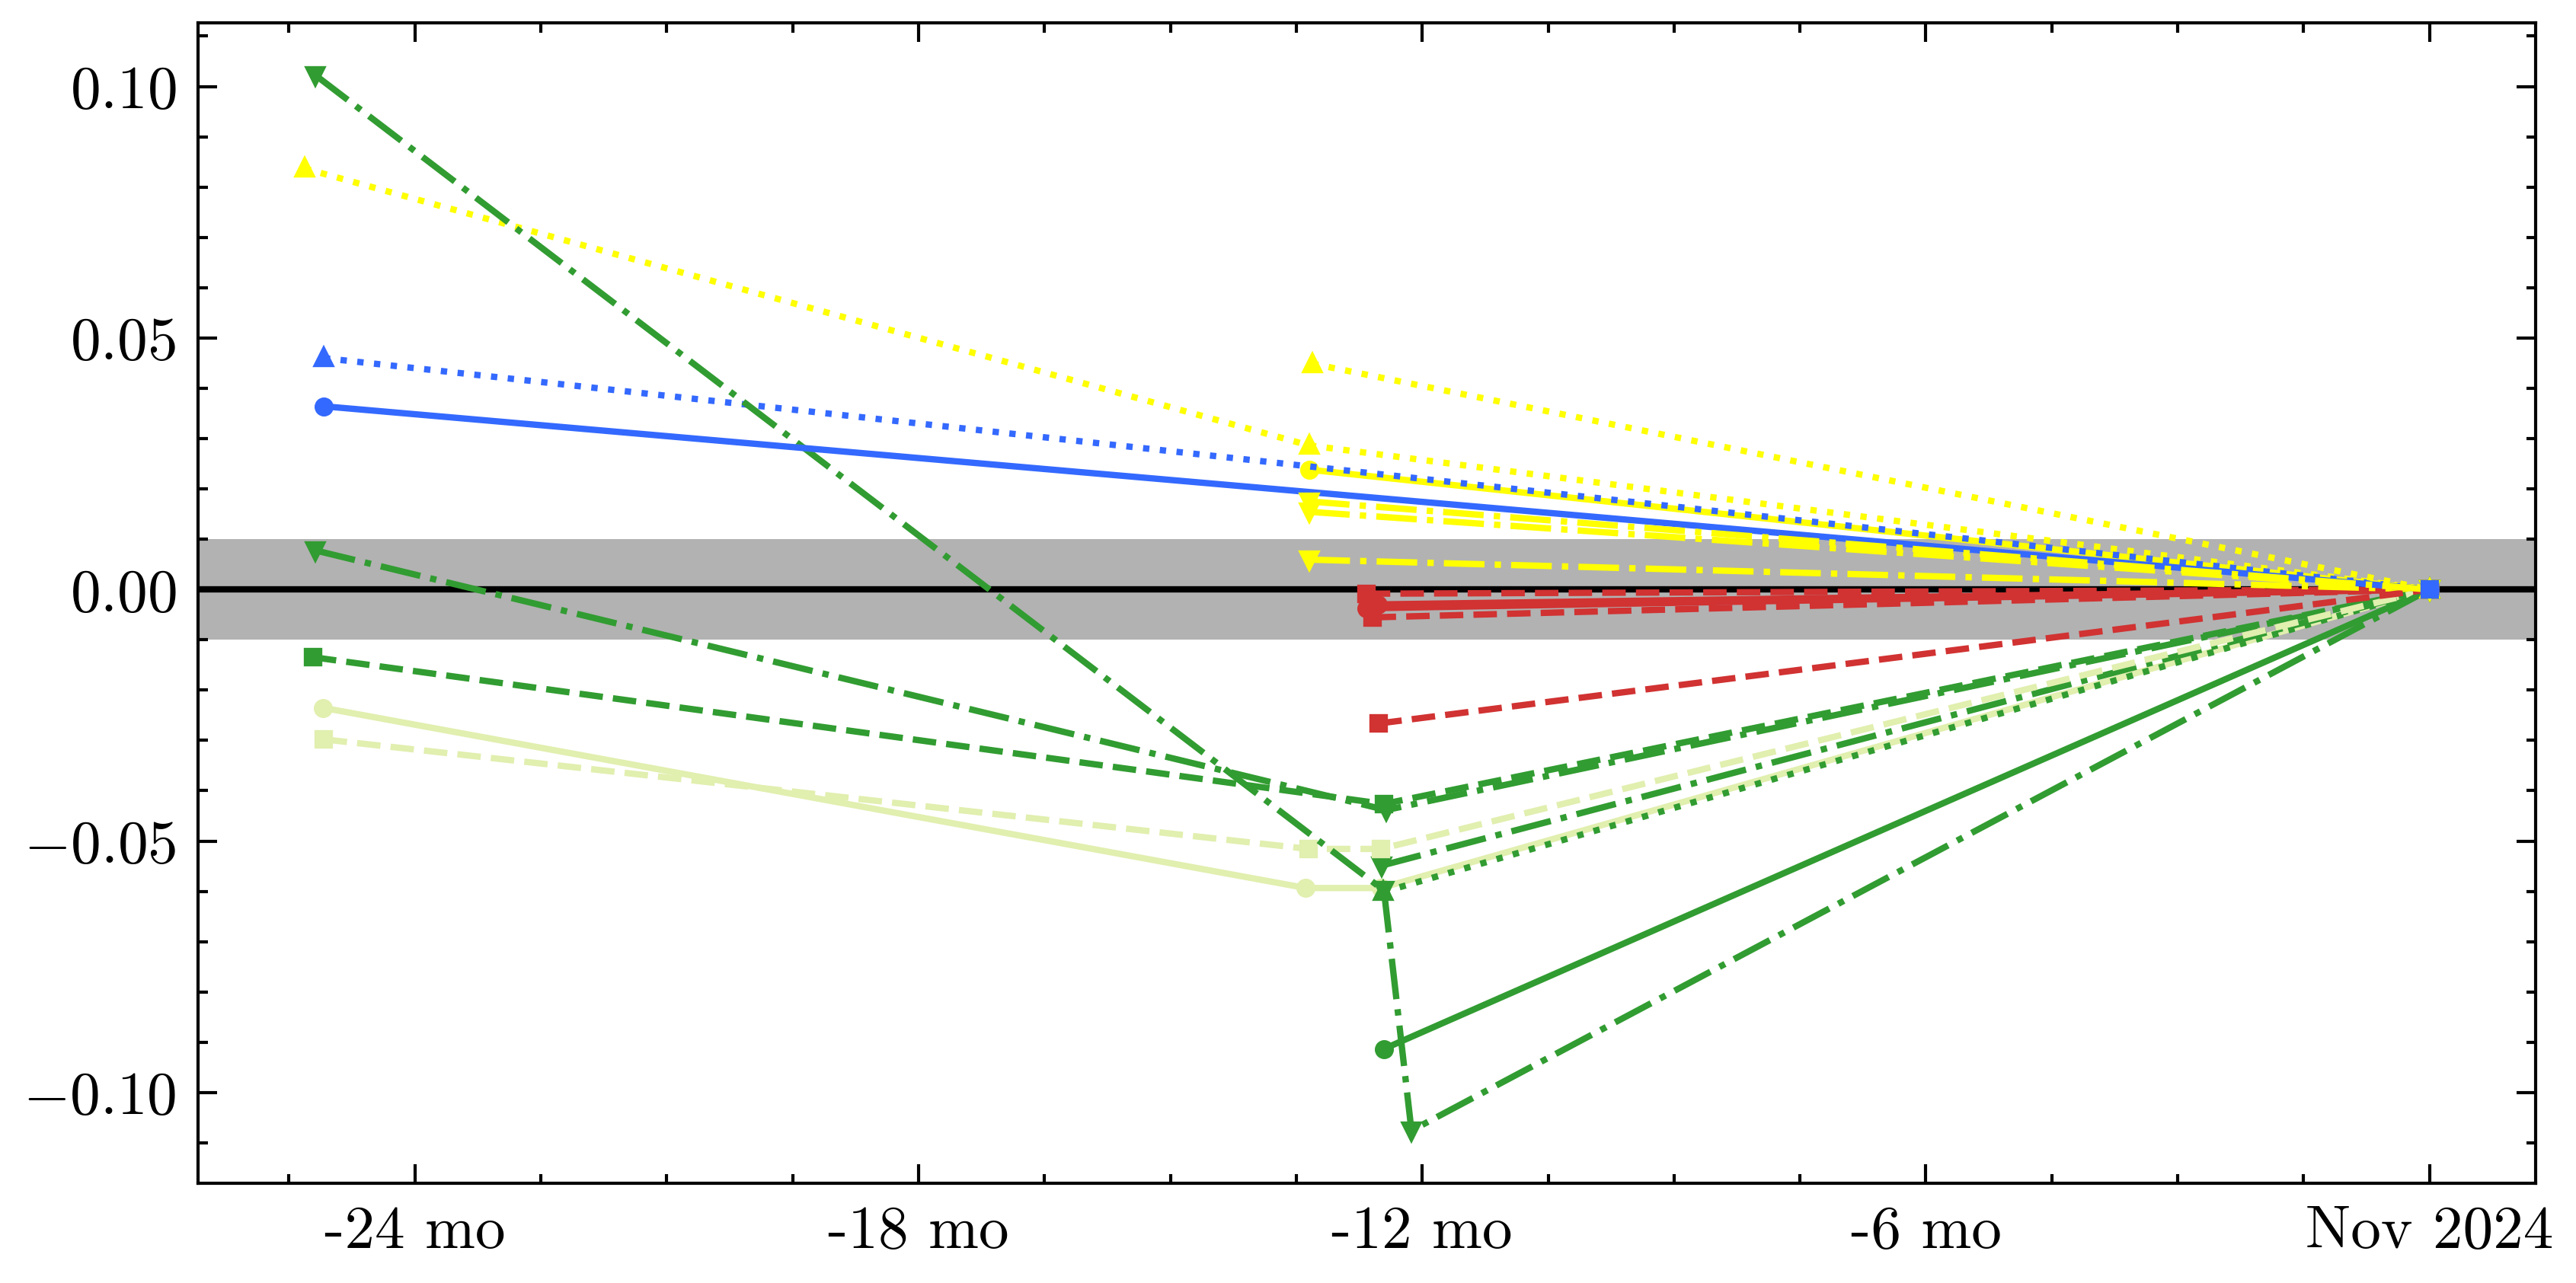

In [30]:
# telescope drift

colors = {
    'll': '#3469ff',
    'lm': '#d13232', 
    'la': '#ffff00', 
    'co': '#319c31', 
    'he1, MC correcte': '#e1efaf',
    'he2, MC correcte': '#e1efaf',
    'he3, MC correcte': '#e1efaf',
}

plt.axhline(0.00)

for tel in dates.keys():
    if len(drift[tel]) < 1: continue

    ii = np.argsort(dates[tel])
    x = np.array(dates[tel])[ii]
    y = np.array(drift[tel])[ii]

    last = np.argmax(x)
    x -= x[last]
    y = (y - y[last]) / y[last]

    # mirror cleaning correction
    if 'he' in tel:
        diff = y[1] - y[2]
        y[:2] -= diff
        tel += ', MC corrected'

    plt.plot([i.total_seconds() for i in x], y, label=tel, c=colors[tel[:-1]])
# plt.scatter(dates, drift)
# np.corrcoef(dates, drift)

_ = plt.xticks(-np.arange(0, 2.5, 0.5) * (365 * 24 * 3600), ['Nov 2024', '-6 mo', '-12 mo', '-18 mo', '-24 mo'])
xlims = plt.gca().get_xlim()
plt.fill_between(xlims, -0.01, 0.01, color='k', alpha=0.3, edgecolor='none')
plt.xlim(*xlims)
# plt.legend(ncols=2)